# MosAIc 

## Einführung

In dem Modul Medienverarbeitung 21/22 war es unsere (Henning Sander, Fynn Ellinghaus, Jannik Wübbe) Aufgabe, eine Technik
zur Erstellung eines digitalen, aus einzelnen Bildern bestehendes Mosaik zu entwickeln.
Die Bearbeitung sowie der Entwicklungsprozess ist mit Zieldefinition, Ansätzen, Erklärungen zur technischen
Umsetzung und Ergebnissen im vorliegenden Dokument festgehalten.

### Begriffsdefinition Mosaik und Zieldefinition
Ein Mosaik, als Gattung der bildenen Künste, bezeichnet ein aus einzelnen, farbigen Elementen
bestehendes Kunstwerk. Diese Technik ist seit dem Altertum bekannt, in dem vorwiegend Fliesen,
Steine, Kiesel, Marmor oder gefärbter Ton in Gips eingedrückt zu einem Kunstwerk angeordnet wurden.
Unser Projekt zielt auf die Entwicklung einer Technik zur Erstellung eines Mosaiks ab, in der moderne Mittel und
Möglichkeiten sowohl den Vorgang als auch die Bestandteile ersetzen. Eine Bibliothek aus Bildern soll hierbei die Elemente,
die es anzuordnen gilt, liefern. Weiter soll auch die Möglichkeit vorhanden sein, aus einer Videodatei einzelne Standbilder (Frames)
auslesen zu können, die dann den Inhalt der Bibliothek bilden. Als Schablone zur Erstellung eines Mosaiks, soll anschließend
ein Bild angegeben beziehungsweise eingelesen werden können.

Genauer: Ziel dieses Projektes soll es sein, aus einer beliebigen Videodatei bzw. Bildergalerie automatisiert und interaktiv
ein Mosaik aus einer Bildvorlage generieren zu können.

In [1]:
import os

import cv2
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [12, 12]
matplotlib.rcParams['figure.dpi'] = 72

#Bild importieren mit RGB Konvertierung
def rgbImport(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

Unsere nächste Intention war es, ein Bild quadratisch zuzuschneiden. Weil ein Pixel ebenfalls quadratisch ist und die von uns genutzten Bilder im 16:9 Format waren, wollten wir diese zuschneiden, um es später einfacher zu haben, die Pixel durch die Bilder zu ersetzen.
Als erstes haben wir mit festen Breiten- (width) und Höhen- (hight) Werten gearbeitet. Mit der mathplotlib-Bibliothek haben wir uns eine Ausgabe erschaffen, damit wir direkt die Resultate sehen können. Weil uns aber bewusst war, dass wir nicht nur mit 1920x1080 Bildern arbeiten werden, haben wir die Funktion verallgemeinert.
Das Bild wird im letzten Schritt testweise quadratisch zugeschnitten und in 256x256 ausgegeben und angezeigt.

## Erste Schritte

In den ersten Schritten war unsere Idee erst einmal anzufangen und die Grundfunktionen des Programmes zu erstellen. Hierzu haben wir zunächst eine Funktion erstellt, die es uns ermöglicht Bilder in Python zu importieren. Weil in OpenCV (Python-Bibliothek) der Farbwert mit BGR (blue/green/red) angegeben wird und wir verhindern wollten, dass sich dadurch Fehler ergeben, haben wir eine Konvertierung eingebaut, die BGR auf RGB (red/green/blue) umschreibt.

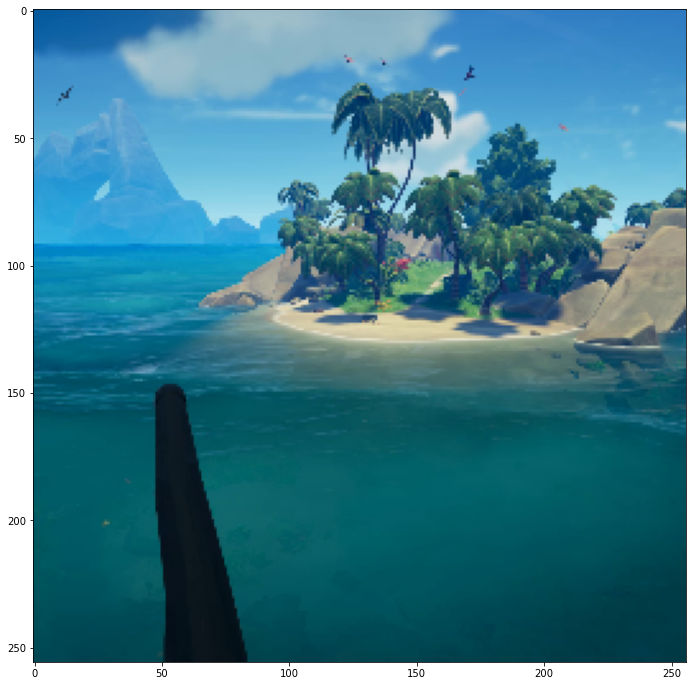

In [2]:
#Beliebiges Bild quadratisch zuschneiden
def quadsizeFix(img):

    height, width, channels = img.shape

    if width > height :
        wStart = int((width - height)/2)
        wEnd = wStart + height
        cropped_image = img[:, wStart:wEnd]
    else :
        hStart = int((height - width)/2)
        hEnd = hStart + width
        cropped_image = img[hStart:hEnd, :]


    return cv2.resize(cropped_image,(256,256))

img = rgbImport("E:/Shadowplay/Sea of Thieves/ffmpeg-N-104475-g1728127e8c-win64-gpl/bin/174.png")
quadImg = quadsizeFix(img)

plt.imshow(quadImg)

Nach späteren Überlegungen, haben wir uns dazu entschlossen, die Methode dynamisch zu gestalten, da wir dem Nutzer die Möglichkeit geben wollen, Einfluss auf die Auflösung des Bildes zu nehmen.

In [3]:
# Beliebiges Bild quadratisch zuschneiden (dynamisch)
def quadsizeOld(img, size):
    height, width, channels = img.shape

    if width > height:
        wStart = int((width - height) / 2)
        wEnd = wStart + height
        cropped_image = img[:, wStart:wEnd]
    else:
        hStart = int((height - width) / 2)
        hEnd = hStart + width
        cropped_image = img[hStart:hEnd, :]

    return cv2.resize(cropped_image, (size, size))

Nachdem wir die Gesichtserkennung integriert hatten (siehe Gesichtserkennung), um alle Bilder der Bibliothek auf Gesichter zuzuschneiden, wurde die Methode überarbeitet und durch zwei Hilfsmethoden ergänzt.
Die Hilfsmethode *quadsize_centered_on_point* schneided das Bild mit auf die übergebene Größe zu, wobei das zugeschnitte Bild das Zentrum möglichst bei dem übergebenen Punkt hat.
*quadsize_centered* nutzt die eben genannte Hilfsmethode, um das Bild auf sein Zentrum zuzuschneiden.
Diese Methode wird genutzt, falls keine Gesichtserkennung genutzt werden soll, oder kein Gesicht gefunden wurde.
Die Methode *quadsize* startet die Gesichtserkennung und ruft abhängig von deren Ergebnis entweder *quadsize_centered* oder *quadsize_centered_on_point* auf.

In [4]:
def quadsize(img, size, crop_to_faces, min_neighbors):
    if crop_to_faces:
        faces = get_faces(img, min_neighbors)
        if len(faces) == 0:
            return quadsize_centered(img, size)

        face_centers = []
        for (x, y, w, h) in faces:
            face_centers.append([x + (w / 2), y + (h / 2)])

        face_centers = np.asarray(face_centers)
        crop_center = np.mean(face_centers, axis=0)
        return quadsize_centered_on_point(img, size, crop_center)

    else:
        return quadsize_centered(img, size)


def quadsize_centered(img, size):
    height, width, channels = img.shape
    return quadsize_centered_on_point(img, size, [width / 2, height / 2])


def quadsize_centered_on_point(img, size, center):
    height, width, channels = img.shape

    if width > height:
        w_start = int(center[0] - (height / 2))
        if w_start < 0:
            w_start = 0

        w_end = w_start + height
        if w_end > width:
            w_start = width - height
            w_end = width

        cropped_image = img[:, w_start:w_end]
    else:
        h_start = int(center[1] - (width / 2))
        if h_start < 0:
            h_start = 0

        h_end = h_start + width
        if h_end > height:
            h_start = height - width
            h_end = height

        cropped_image = img[h_start:h_end, :]

    return cv2.resize(cropped_image, (size, size))

Der folgende Ansatz war es, dass das Bild verpixelt wird, um eine kleinere Detaildichte zu erreichen.
Hierzu wurde die dynamische Verpixelung genutzt.
Mit dieser Methode wird jedes Bild welches eingelesen wird um den Faktor 12 komprimiert.
Unsere Idee war es dadurch den Farbwert besser bestimmen zu können und Ressourcen zu sparen.

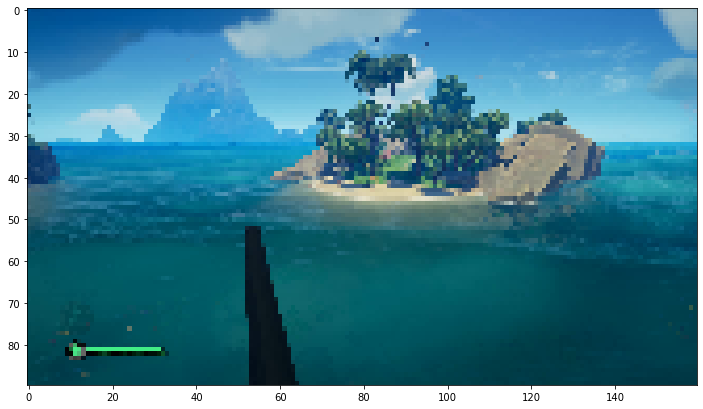

In [5]:
#Komprimierungsansatz mittels dynamischer Verpixelung
def destroyImgDyn(img):
    height, width, channels = img.shape
    img = cv2.resize(img,(int(width/12),int(height/12)))
    return img

toDestroyImg = rgbImport("E:/Shadowplay/Sea of Thieves/ffmpeg-N-104475-g1728127e8c-win64-gpl/bin/174.png")
plt.imshow(destroyImgDyn(toDestroyImg))

Um es zu vereinfachen, haben wir eine fast gleiche Methode geschrieben, welche das Bild auf die feste Größe von 128x72 komprimiert. 

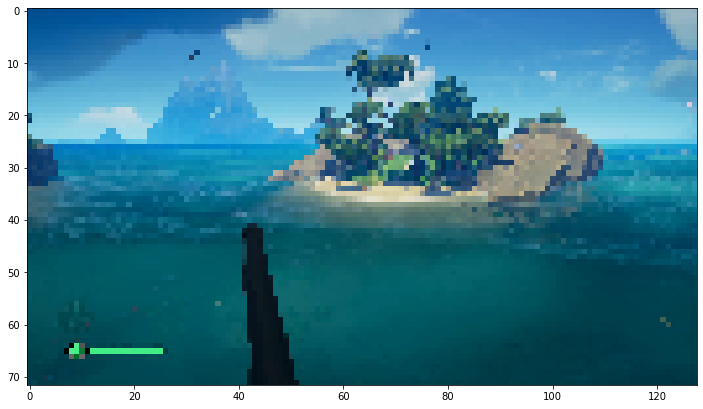

In [6]:
#Komprimierungsansatz auf feste Größe (TODO: auch Hochkanntbilder sollen unterstützt werden)
def destroyImgFix(img):
    img = cv2.resize(img,(128,72))
    return img

plt.imshow(destroyImgFix(toDestroyImg))

Da durch *destroyImgDyn* die Auflösung des Originalbildes Einfluss auf die Größe des Mosaiks hat und
*destroyImgFix* ein einheitliches Seitenverhältnis voraussetzt haben wir uns für die folgende Lösung entschieden.

Dieser Methode werden Parameter zur Breite und Höhe übergeben, welche anschließend verwendet werden, das Bild zu skalieren.
Abschließend wird das skalierte Bild zurückgegeben.

In [7]:
# Komprimierungsansatz auf feste Größe
def destroyImg(img, width, height):
    img = cv2.resize(img, (width, height))
    return img

Der nächste Schritt war es von einem Bild den durschschnittlichen Farbwert zu bestimmen. Dieses soll uns später die Möglichkeit geben Farbwerte zu vergleichen. 
Hierzu wurde die folgende Methode geschrieben. Der Gedanke war, das Bild auf eine Größe von 1x1 Pixel zuzuschneiden, um dadurch den mittleren Farbwert zu erhalten.
Dies entpuppte sich als ein Fehler, weil es uns dadurch einen verfälschten Wert für uns geliefert hat. So wurden beispielsweise Bereiche in einem Bild dunkel dargestellt, obwohl diese eigentlich hell sein müssten.
Diese Methode wurde durch die *getColorValue* Methode ersetzt.

In [8]:
#Methode, die den durschnittlichen Farbwert eines Bildes liefert
def getColorValueWRONG(img):
    img = cv2.resize(img, (1,1))
    return img[0][0]

getColorValueWRONG(img)

array([209, 201, 167], dtype=uint8)

In der *getColorValue Methode* ermitteln wir den durschnittlichen Farbwert.

In [9]:
#Methode, die den durschnittlichen Farbwert eines Bildes liefert
def getColorValue(img):
    return img.mean(axis=0).mean(axis=0)

getColorValue(img)

array([ 42.76270158, 114.94576003, 137.80174286])

Mit den vorhandenen Methoden ist es uns möglich die Farbwerte zu bestimmen und im nächsten Schritt sollen zwei Farbwerte miteinander verglichen werden können. Hierzu nutzen wir die Euklidische Distanz im dreidiminsionalen Raum:

$$d(p,q) = \sqrt{(q1 - p1)^2 + (q2 - p2)^2 + (q3 - p3)^2} = \sqrt {\sum \limits _{i=1} ^{n=3}(qi - pi)^2}$$

Der Sinn dieser Methoden ist es, den Farbwert eines Pixels zu bestimmen und diesen mit dem mittleren Farbwert eines Bildes vergleichen zu können.
Dies ermöglicht es uns ein Bild zu finden, dessen durchschnittlicher Farbwert dem Farbwert des Pixels am meisten ähnelt, um später diesen Pixel durch das Bild zu ersetzen.
Wenn dies für jeden Pixel durchgeführt wird, sollte am Ende ein Mosaik entstehen, welches sehr ähnliche Farbwerte aufweist und das Schablonenbild sehr nah imitert.

In [10]:
#Euklidische Distanz berechen (Farbunterschied)
def getColorDifference(color1, color2):
    return math.sqrt((int(color1[0])- int(color2[0]))**2+(int(color1[1]) - int(color2[1]))**2+(int(color1[2])- int(color2[2]))**2)

getColorDifference(getColorValue(img),getColorValue(toDestroyImg))

NameError: name 'math' is not defined

Weil ein Mosaik nicht nur aus einem Bild, sondern aus vielen besteht, haben wir uns ein Programm gesucht, welches uns aus einer Videodatei eine Bilderbibliothek erstellen kann. Dieses heißt ffmpeg und kann fast alle gängigen Videoformate lesen und bearbeiten. Es wird über die Eingabeaufforderung gestartet.
Mit den folgenden Parametern lesen wir die Videodatei und erhalten einzelne Bilder.

                ffmpeg -i video.mp4 -vf fps=1/5 bib/out%d.jpeg
        
ffmpeg startet das Programm. Danach wird der Dateipfad der Videodatei angegeben (in unserem Fall in dem Ordner des Programms selbst). Mit -vf wird dem Programm mitgeteilt, dass wir Videoframes haben wollen und mit den fps geben wir an, dass wir alle fünf Sekunden ein Frame (Bild) haben wollen. Zuletzt geben wir den Ausgabeordner (bib) an und den Namen sowie das Dateiformat (jpeg), den das Bild haben soll. Mit %d werden die Bilder automatisch durchnummeriert.

Anfangs haben wir selbst aufgenommene Videodateien aus dem Videospiel "Hunt: Showdown" genutzt. Hier wird später noch näher drauf eingegangen. 

Mit der *getAllImages Methode*, werden alle Bilder aus der Bilderbibliothek in ein Array geladen. Uns wird zur Bestätigung die Länge des Arrays (Anzahl der Bilder) und ein Beispielbild ausgegeben.

Diese Methode wurde später in die Datenbank augelagert (siehe *importAllImages*).

In [ ]:
#Funktion, die Bilder importiert
def getAllImages(folderPath):
    images = []
    for filename in os.listdir(folderPath):
        img = rgbImport(os.path.join(folderPath, filename))
        if img is not None:
            images.append(img)
    return images

allImages = getAllImages("E:/Shadowplay/Sea of Thieves/ffmpeg-N-104475-g1728127e8c-win64-gpl/bin/out")
print(len(allImages))
plt.imshow(allImages[0])

Jetzt werden mit *cropAllImages* alle Bilder zugeschnitten. Dies geschieht mit der *quadsize* Methode vom Anfang.

In [ ]:
#Schneidet alle Bilder zu
def cropAllImages(allImages):
    allCroppedImages = []
    for img in allImages:
        allCroppedImages.append(quadsize(img))
    return allCroppedImages

plt.imshow(cropAllImages(allImages)[1])

Weiter werden alle Farbwerte der einzenen Bilder bestimmt und in dem *allColorValues* Array abgespeichert.

In [ ]:
#Ermittelt die durchschnittlichen Farbwerte aller Bilder
def getAllColorValues(allImages):
    allColorValues = []
    for img in allImages:
        allColorValues.append(getColorValue(img))
    return allColorValues

getAllColorValues(allImages)[1]

Es ist an der Zeit alles zusammenzuführen. In der *createMosaic* Methode wird zunächst mit dem *originImg* das Bild, welches als Schablone dienen soll, mit der *destroyImgFix* in die gewünschte Verpixelung und Größe gebracht.
Dann werden Höhe, Breite und die Kanäle ausgelesen.
Nun wird das Bild zeilenweise durchlaufen und für jeden Pixel des *originImg* (der Schablone) werden die Farbwerte mit denen in dem *allColorValues* Array verglichen, um den Farbwert mit dem geringsten Abstand zu finden. Wenn der minimalste Abstand gefunden wurde, wird das Bild aus dem Array *allCroppedImages* an der Position des Farbwertes angehangen. Dies wird konkatenierend durchgeführt, bis das gesamte Bild durchlaufen wurde.

In [ ]:
#Erstellt das MosAIc
def createMosaicOld(originImg, allCroppedImages, allColorValues):
    originImg = destroyImgFix(originImg)
    height, width, channels = originImg.shape
    col = []
    for y in range(height):
        row = []
        for x in range(width):
            minDif = 500
            for i in range(len(allColorValues)):
                value = allColorValues[i]
                dif = getColorDifference(value, originImg[y,x])
                if dif < minDif:
                    minDif = dif
                    minDifPosition = i
            row.append(allCroppedImages[minDifPosition])
        col.append(np.concatenate(row, axis = 1))
    return cv2.cvtColor(np.concatenate(col, axis = 0), cv2.COLOR_BGR2RGB)

images = getAllImages("E:/Shadowplay/Sea of Thieves/ffmpeg-N-104475-g1728127e8c-win64-gpl/bin/out")

mosaic = createMosaicOld(rgbImport("E:/Shadowplay/Sea of Thieves/ffmpeg-N-104475-g1728127e8c-win64-gpl/bin/174.png"), cropAllImages(images), getAllColorValues(images))
cv2.imwrite("E:/Shadowplay/Sea of Thieves/ffmpeg-N-104475-g1728127e8c-win64-gpl/bin/output.jpeg", mosaic)
#plt.imshow(mosaic)

Um den initialen Wert von *minDiff* zu ermitteln, testeten wir zunächst, was der theoretisch größte Farbwertunterschied sein kann.
Hierzu haben wir einen schwarzen Pixel mit einem weißen verglichen.
Das Resultat haben wir großzügig aufgerundet, sodass jede ermittelte Distanz auf jeden Fall geringer ist, als der Initialwert.

In [ ]:
#Größter Farbwertunterschied
getColorDifference([255,255,255],[0,0,0])

Der erste Versuch der Mosaik-Generierung schlug fehl, weil wir falsche Werte genutzt hatten, sodass Bilder mit 1080x1080 aneinander gehängt wurden.
Dies hat den Arbeitsspeicher eines PC's in die Knie gezwungen, nachdem eine Dateigröße von 7,81GB erschaffen wurde und der Prozess noch nicht beendet war.
Nach diesem Fehler wurden kleiner Werte für die *destroyImgFix* Methode gewählt.

Allerdings bestanden etwaige Probleme auch nach Anpassung der Größe, was uns veranlasste, eine Datenbank zu implementieren (siehe Datenbank).

Zudem wurden weitere Features implementiert, nachdem die erste Erstellung einmal geglückt war.

## Mosaik-Generierung

Die folgende Methode *getMosaicElementIDs* erstellt eine Matrix aus Bild-IDs (im Folgenden ID-Matrix genannt), die die Anordnung des endgültigen Mosaiks repräsentiert.
Dazu liest sie alle Bild-IDs mitsamt ihrer durchschnittlichen Farbwerte aus der Datenbank.
Anschließend wird durch alle Pixel des übergebenen Bildes iteriert, und zu jedem Pixel die Bild-ID mit dem passendsten durchschnittlichen Farbwert ermittelt und zu einer Matrix hinzugefügt.
Diese Matrix wird als eine Art Schablone für die Erstellung von "normalen" und detail Mosaiken verwendet.

In [ ]:
def getMosaicElementIDs(originImg, allColorValuesWithIDs, progressBar):
    ids = allColorValuesWithIDs[:, 0]
    colorValues = allColorValuesWithIDs[:, 1:]
    height, width, channels = originImg.shape

    progressBar.setMaximum(height * width * 2)
    progressBarValue = 0

    id_matrix = []
    for y in range(height):
        id_matrix_row = []
        for x in range(width):
            minDif = 500
            for i in range(len(colorValues)):
                value = colorValues[i]
                dif = getColorDifference(value, originImg[y, x])
                if dif < minDif:
                    minDif = dif
                    minDifID = ids[i]

            id_matrix_row.append(minDifID)
            progressBarValue += 1
            progressBar.setValue(progressBarValue)
            QApplication.processEvents()
        if y == 0:
            id_matrix = id_matrix_row
        else:
            id_matrix = np.vstack([id_matrix, id_matrix_row])

    return id_matrix

In der *createMosaic* Methode wird die in der vorangegangenen Funktion erstellte Matrix zunächst genutzt, um genau die Bilder aus der Datenbank zu lesen, die im endgültigen Mosaik benötigt werden.
Dadurch müssen nicht mehr, wie noch in der createMosaicOld-Funktion, alle Bilder der Bibliothek in den Arbeitsspeicher geladen werden, was die Performance für große Bibliotheken stark verbessert, während die Gefahr eines PC-Absturzes minmiert wird.
Anschließend werden die Bilder so zusammengesetzt, dass sie der Reihenfolge ihrer IDs in der ID-Matrix entsprechen.
Das daraus entstandene Mosaik wird von der Methode zurückgegeben.

In [ ]:
def createMosaic(originImg, allColorValuesWithIDs, elementSize, db, progressBar):
    id_matrix = getMosaicElementIDs(originImg, allColorValuesWithIDs, progressBar)
    croppedImagesWithIDs = np.array(db.getCroppedImagesWithIDByID(np.unique(id_matrix), elementSize))
    progressBarValue = progressBar.value()

    mosaic_img = []
    for id_matrix_row in id_matrix:
        mosaic_row = []
        for id in id_matrix_row:
            img_to_append = croppedImagesWithIDs[croppedImagesWithIDs[:, 0].astype(int) == id, 1][0]
            mosaic_row.append(img_to_append)
            progressBarValue += 1
            progressBar.setValue(progressBarValue)
            QApplication.processEvents()
        mosaic_img.append(np.concatenate(mosaic_row, axis=1))

    return cv2.cvtColor(np.concatenate(mosaic_img, axis=0), cv2.COLOR_BGR2RGB)

Um ein detail Mosaik zu erstellen, wird grundsätzlich analog zu dem Erstellvorgang eines normalen Mosaiks vorgegangen.
Vor dem Erstellen des Mosaiks werden allerdings Elemente, die dieselbe ID haben zu einem größeren Bild zusammengefasst (siehe *checkForCombinableImages* und *combineImages*).
Dazu wird zunächst die Bild-ID-Matrix verändert und mit zusätzlichen Informationen versehen.
Um diese zusätzlichen Informationen speichern zu können, wird der ID-Matrix eine dritte Dimension angefügt, in der ab sofort drei Werte gespeichert werden sollen:

1. die Größe des aktuellen Mosaik-Elements (Standardwert: *minSize*)
2. den Y-Wert in dem aktuellen Mosaik-Element (Standardwert: 0)
3. den X-Wert in dem aktuellen Mosaik-Element (Standardwert: 0)

Hintergrund dieser Zusatzinformationen ist, dass das Mosaik in unserer Architektur weiterhin aus gleich großen Bildern zusammen gesetzt werden muss, in unserem Fall also Bildern der Größe *minSize*.
Sollen also vier Bilder zu einem zusammengefasst werden, so wird in der ID-Matrix in allen vier "Zellen" dieselbe ID eingetragen, die Größe (Kantenlänge) verdoppelt und die X-/Y-Werte je nach Position des Elements angepasst.

Wurden die Bilder mittels der Hilfsfunktionen zusammengefasst, wird die Matrix analog zu *createMosaik* zusammengesetzt, wobei die Zusatzinformationen natürlich berücksichtigt werden.

In [ ]:
#  Erstellt das DetailMosAIc
def createDetailMosaic(originImg, allColorValuesWithIDs, minSize, maxSize, allowed_deviation, db, progressBar,
                       useEdgeDetection):
    if useEdgeDetection:
        edges = getEdges(originImg)
    else:
        edges = np.full((originImg.shape[0], originImg.shape[1]), 0)

    id_matrix = getMosaicElementIDs(originImg, allColorValuesWithIDs, progressBar)
    croppedImagesWithIDs = []

    for i in range(int(math.log2(maxSize / minSize)) + 1):
        croppedImagesWithIDs.append(
            np.array(db.getCroppedImagesWithIDByID(np.unique(id_matrix), minSize * (2 ** i))))

    progressBarValue = progressBar.value()

    id_matrix = np.expand_dims(id_matrix, axis=2)
    new_dim = np.full((len(id_matrix), len(id_matrix[0]), 1), minSize)  # size
    id_matrix = np.append(id_matrix, new_dim, axis=2)
    new_dim2 = np.full((len(id_matrix), len(id_matrix[0]), 1), 0)  # x/y value
    id_matrix = np.append(id_matrix, new_dim2, axis=2)
    id_matrix = np.append(id_matrix, new_dim2, axis=2)

    combineImages(id_matrix, maxSize, minSize, allowed_deviation, edges)

    mosaic_img = []
    for id_matrix_row in id_matrix:
        mosaic_row = []
        for id, size, y, x in id_matrix_row:
            croppedImagesToUse = croppedImagesWithIDs[int(math.log2(size / minSize))]
            img_to_append = croppedImagesToUse[croppedImagesToUse[:, 0].astype(int) == id, 1][0]
            y = int(y)
            x = int(x)
            img_to_append = img_to_append[y:(y + minSize), x:(x + minSize), ]
            mosaic_row.append(img_to_append)
            progressBarValue += 1
            progressBar.setValue(progressBarValue)
            QApplication.processEvents()
        mosaic_img.append(np.concatenate(mosaic_row, axis=1))

    return cv2.cvtColor(np.concatenate(mosaic_img, axis=0), cv2.COLOR_BGR2RGB)

Die rekursive Funktion *combineImages* verändert die übergebene ID-Matrix so, dass aus einem "normalen" Mosaik ein detail Mosaik wird.
Dazu wird ihr bei jedem Aufruf der aktuelle Stand der ID-Matrix, die aktuelle Elementgröße, die minimale Elementgröße, eine erlaubte Abweichung sowie Kanten aus der Kantenerkennung übergeben.
Beim ersten Aufruf wir die aktuelle auf die maximale Elementgröße gesetzt und bei jedem rekursiven Aufruf halbiert, bis die minimale Größe erreicht ist.

Die Funktion iteriert nun durch alle Elemente in der ID-Matrix und prüft jedes Mal mittels der Funktion *checkForCombinableImages*, ob die Elemente kombiniert werden können.
Ist dies der Fall, werden alle betreffenden Elemente angepasst.

In [ ]:
def combineImages(id_matrix, img_size, min_img_size, allowed_deviation, edges):
    for row_idx, id_matrix_row in enumerate(id_matrix):
        for col_idx, [id, size, y, x] in enumerate(id_matrix_row):
            if row_idx + img_size / min_img_size > len(id_matrix) \
                    or col_idx + img_size / min_img_size > len(id_matrix_row):
                continue

            combinable, most_used_img_id = checkForCombinableImages(id_matrix, row_idx, col_idx, img_size, min_img_size,
                                                                    edges, allowed_deviation)
            if not combinable:
                continue

            for y in range(int(img_size / min_img_size)):
                for x in range(int(img_size / min_img_size)):
                    id_matrix[row_idx + y, col_idx + x, 0] = most_used_img_id
                    id_matrix[row_idx + y, col_idx + x, 1] = img_size
                    id_matrix[row_idx + y, col_idx + x, 2] = y * min_img_size
                    id_matrix[row_idx + y, col_idx + x, 3] = x * min_img_size

    if (img_size / 2) > min_img_size:
        combineImages(id_matrix, int(img_size / 2), min_img_size, allowed_deviation, edges)

Durch diese Funktion wird geprüft, ob das Element an der übergebenen Position mit den Elementen links und unten zu einem größeren Element kombiniert werden kann.
Dafür gelten die folgenden Bedingungen:

1. Die zu kombinierenden Elemente müssen alle die minimale Größe haben, da sie sonst bereits in einem größeren Element zusammengefasst sind.
2. Die zu kombinierenden Elemente dürfen nicht auf einer erkannten Kante liegen.
3. Der Anteil abweichender Elemente muss kleiner sein, als die erlaubte Abweichung.

Sind diese drei Bedingungen erfüllt, wird "True" sowie die am häufigsten auftretende ID zurückgegeben, andernfalls False sowie ein nicht definierter integer.

In [ ]:
def checkForCombinableImages(id_matrix, row, col, img_size, min_img_size, edges, allowed_deviation):
    dict = {}
    for r in range(int(img_size / min_img_size)):
        for c in range(int(img_size / min_img_size)):
            if id_matrix[row + r, col + c, 1] != min_img_size:
                return False, -1
            if edges[row + r, col + c] != 0:
                return False, -1

            id = id_matrix[row + r, col + c, 0]
            dict[id] = dict.get(id, 0) + 1

    amount_of_small_imgs = int(img_size ** 2 / min_img_size ** 2)
    return amount_of_small_imgs - max(dict.values()) <= allowed_deviation * amount_of_small_imgs, max(dict,
                                                                                                      key=dict.get)

In der folgenden Methode wird der aus der Vorlesung bekannte "Canny"-Algorithmus zur Kantenerkennung genutzt. Der Canny Algorithmus nutzt das Ergebnis des Sobel-Algorithmus und gibt uns nur die echten Kanten aus. Zunächst nutzt der Sobel-Algorithmus Faltungsmatritzen (convolution kernel) um mögliche Kanten zu erkennen. Hierzu wird das Bild in Schwarz/Weiß konvertiert und anschließend in der x- als auch in der y-Richtung geschaut, ob die direkten Nachbarpixel heller oder dunkler sind. Um zu erkennen, in welche Richtung die Kante verläuft werden der x- und y-Wert genommen und mittels der Formel: $$G = \sqrt{Gx² + Gy²}$$
der Gradiant bestimmt. Mittels diesem lässt sich die Kante anzeigen. Sobel zeigt Kanten an, welche wir nicht benötigen. Hier kommt der Canny-Algorithmus in Aktion. Dieser nutzt die von Sobel erkannten Kanten und deren Richtung um die kleinst mögliche Kante zu finden. Hierzu vergleicht Canny die x- und y-Nachbarwerte der Kante miteinander und kann so das perfekte Mittelmaß finden und die "echte" Kante. Weil in einem Bild Kanten nicht immer gleich scharf dargestellt werden, werden Canny ein minimaler und maximaler Wert übergeben. Alle Kanten die einen höheren Wert haben als der max-Wert, werden automatisch übernommen und alle die zwischen den min- und max-Wert liegen und mit der Kante verbunden sind die über dem max-Wert liegt, werden auch übernommen. So lassen sich durch Feinjustierungen exakte Kanten darstellen lassen.
Wir verwenden in unsere Methode eine Implementierung aus OpenCV, die das oben beschriebene umsetzt.

In [ ]:
def getEdges(img):
    return cv2.Canny(img.astype(np.uint8), 100, 250)

Die folgenden drei Methoden können genutzt werden, um das Mosaik mit dem Originalbild zu hinterlegen.
Dadurch kann je nach Einstellung mehr oder weniger unauffällig die Erkennbarkeit des dargestellten Objektes verbessert werden.

Wir haben im Ramen unserer Tests festgestellt, dass diese Technik unauffälliger wird, je feiner das Mosaik aufgelöst ist, da die Kanten bei hochauflösenden Mosaiken ohnehin schon gut zu erkennen sind, und somit weniger Kanten des Originalbildes mitten durch ein Element verlaufen.
Gerade für kleinere Bibliotheken kann dieses feature hilfreich sein, dadurch die Farben der Elemente noch leicht "korrigiert" werden können.
Es gilt aber zu beachten, dass darunter die Qualität der einzelnen Elemente leidet, da deren Farbwerte anschließend korrumpiert sind.

Die erste Methode bekommt zwei Bilder übergeben, das fertige Mosaik und das Originalbild, sowie eine Matrix, die die gleiche Größe wie das Mosaik sowie Werte in [0,1] aufweisen muss.
Diese Matrix bestimmt, wie stark und in welcher Form das Originalbild eingeblendet wird. 0 bedeutet dabei, dass das Originalbild gar nicht zu sehen ist, 1, dass nur das Originalbild zu sehen ist.
Dazu wird das Originalbild zunächst auf dieselbe Größe wie das Mosaik gebracht.
Anschließend werden alle Farbwerte des Originalbildes mit dem jeweiligen Wert aus der Alpha-Matrix und alle Farbwerte des Mosaiks mit dem Kehrwert der Alpha-Matrix multipliziert.
Dann werden die beiden Bilder übereinander gelegt, indem die Farbwerte addiert werden.

In [ ]:
def addTransparentPicture(mosaic, img, alpha):
    height, width, channels = mosaic.shape
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (width, height))

    img = img.astype(float)
    mosaic = mosaic.astype(float)
    alpha = alpha.astype(float)
    img = cv2.multiply(alpha, img)
    mosaic = cv2.multiply(1 - alpha, mosaic)
    return cv2.add(mosaic, img)

Diese Methode wird genutzt, um die Bild gleichmäßig übereinander zu legen.
Dazu wird eine Alpha-Matrix mit der übergebenen Prozentzahl erstellt und *addTransparentPicture* übergeben.

In [ ]:
def addOriginalPicture(mosaic, img, percentage):
    alpha = np.full_like(mosaic, (percentage / 100), dtype=float)
    return addTransparentPicture(mosaic, img, alpha)

Im Gegensatz zur vorangegangenen Methode kreiert diese einen linearen Verlauf.
Je nach übergebenen Einstellungen kann das Originalbild von oben nach unten oder von links nach rechts eingeblendet werden.
Zudem kann die Alpha-Maske auch invertiert werden, sodass das Bild ebenfalls von unten nach oben oder von rechts nach links eingeblendet werden kann.

In [ ]:
def fadeToOriginalPicture(mosaic, img, topDown, inverted):
    height, width, channels = mosaic.shape

    alpha = np.full_like(mosaic, 0)
    alpha = alpha.astype(float)

    if topDown:
        a_vect = np.empty(width)
        a_vect = a_vect.astype(float)
        for i in range(height):
            a = i/(height-1)
            a_vect.fill(a)
            alpha[i, :] = a
    else:
        a_vect = np.empty(height)
        a_vect = a_vect.astype(float)
        for i in range(width):
            a = i/(width-1)
            a_vect.fill(a)
            alpha[:, i] = a

    if inverted:
        inv = np.full_like(mosaic, 1.0)
        alpha = np.subtract(inv, alpha)

    return addTransparentPicture(mosaic, img, alpha)

## Gesichtserkennung
Stock-Fotos von https://www.pexels.com/

Die Bilder, die später als Elemente des Mosaiks genutzt werden sollen, werden bisher immer auf die Mitte zugeschnitten, um das Bild auf ein quadratisches Seitenverhältnis zu bringen.
Diese Methode ist allerdings nicht immer sinnvoll, da sich das Objekt, das in dem Bild abgebildet werden soll, nicht immer in der Mitte des Bildes befindet.

Zwar würde es den Rahmen dieses Projektes sprengen, wenn wir versuchen würden dieses Problem grundsätzlich zu lösen, beispielhaft wollen wir dieses aber bei einer Art von Bildern lösen: bei Portraits.
Ziel ist es also, das quadratische Zuschneiden von Bildern so zu gestalten, dass Gesichter möglichst nicht abgeschnitten oder gar aus dem Bild entfernt werden.
Hierzu nutzen wir eine Gesichtserkennung, die später dazu genutzt werden soll, Bilder nicht mehr auf die Mitte zuzuschneiden, sondern zentriert auf das erkannte Gesicht (siehe *quadsize*).
Sollten mehrere Gesichter erkannt werden, soll das Bild auf den Mittelpunkt der Gesichter zugeschnitten werden, sodass, sollten z. B. zwei Personen abgebildet sein, möglichst beide auf dem zugeschnittenen Bild zu sehen sind.
Dadurch ist zwar nicht sichergestellt, dass kein Gesicht abgeschnitten wird, die Wahrscheinlichkeit ist aber stark reduziert, ohne nur auf spezifische Szenarien einzugehen.

Für die Implementierung der Gesichtserkennung nutzen wir die Implementierung des aus der Vorlesung bekannten Viola-Jones Algorithmus.
Dieser Algorithmus arbeitet auf den Graustufen eines Bildes und erkennt Bilder anhand von charakteristischen Merkmalen, wie beispielsweise der Tatsache, dass die Augenpartie eines Menschen dunkler ist, als die oberen Wangen.
Anhand dieses und anderer Merkmale wird das Bild durchsucht und so Gesichter erkannt.

Für einen ersten Test wurde zunächst das Testbild importiert und eine Kopie in Graustufen erzeugt.
Auf diese Kopie wurde dann der Algorithmus angewendet.
Die Position der erkannten Bilder wird anschließend als ein Rechteck auf dem Original-Bild dargestellt.
Bei diesem Test mit verschiedenen Bildern fiel schnell auf, dass der optimale Wert für *minNeighbors* von Bild zu Bild stark variiert.
Dieser muss später also vom Nutzer an die entsprechenden Bilder angepasst werden können.

In [ ]:
img = rgbImport("bib_stock_faces/pexels-mart-production-7328509.jpg")
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(img_gray, minNeighbors=15)
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
plt.imshow(img)


Nachdem der erste Test erfolgreich war, wurde eine Funktion erstellt, die äquivalent zu dem oben gezeigten Test die Position der Gesichter ermittelt.
Statt einen Rahmen um die Gesichter zu zeichnen, wird dessen Position aber zurückgegeben, sodass diese zum Zuschneiden der Bilder genutzt werden kann.

In [ ]:
def get_faces(img, min_neighbors):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    return face_cascade.detectMultiScale(img_gray, minNeighbors=min_neighbors)



## Datenbank

Die Datenbank in unserem Projekt soll mehrere Zwecke erfüllen.
Zum einen soll sie dabei helfen, die Arbeitsspeicher-Belastung zu minimieren.
Dazu sollen die Bilder während des Importvorgangs einzeln in verschiedenen Auflösungen in die Datenbank gespeichert werden.
Zudem wird für jedes Bild der durchschnittliche Farbwert gespeichert.
Beim Erstellen des Mosaiks müssen nun nicht alle Bilder der Bibliothek in den Arbeitsspeicher geladen werden.
Stattdessen wird mit der ID und den Farbwerten gearbeitet, sodass am Ende des Vorgangs eine ID für jede Stelle des Mosaiks vorliegt, die beschreibt, welches Bild an dieser Stelle eingesetzt werden soll.
Beim zusammensetzten des Mosaiks müssen nun nur die Bilder aus der Datenbank geladen werden, die auch in das Mosaik eingesetzt werden sollen (siehe Mosaik-Generierung).
Dadurch skaliert die Arbeitsspeicher-Belastung nicht mehr mit der Größe der Bibliothek, sondern ausschließlich mit der Größe des Mosaiks.

Ein weiterer Vorteil der Datenbank ist, dass eine einmal importierte Bibliothek auch nach Neustart der Anwendung noch vorhanden ist, was es dem Nutzer ermöglicht, direkt ein Mosaik zu erstellen.
Insbesondere für unsere Tests war das sehr hilfreich und hat uns viel Zeit erspart.

In [ ]:
import sqlite3
import cv2
import mosaic

class Database:
    db_path = "mosaic.db"

Im Konstruktor der Datenbank-Klasse wird zunächst eine Verbindung zur SQLite-Datei aufgebaut.
Hierbei wird die Datei neu erstellt, falls sie nicht vorhanden ist.

Zudem wird die Tabelle "image" neu erstellt, falls sie nicht schon vorhanden ist.
Dadurch ist gewährleistet, dass diese Tabelle auch existiert, falls der Nutzer vorher die Datenbank-Datei gelöscht hat.

In [ ]:
    def __init__(self):

        self.connection = sqlite3.connect(self.db_path)

        cursor = self.newCursor()
        cursor.execute('''CREATE TABLE IF NOT EXISTS image (
                            image_id INTEGER PRIMARY KEY AUTOINCREMENT,
                            img_original TEXT,
                            img_cropped_32 TEXT,
                            img_cropped_64 TEXT,
                            img_cropped_128 TEXT,
                            img_cropped_256 TEXT,
                            img_cropped_512 TEXT,
                            color_r REAL,
                            color_g REAL,
                            color_b REAL);''')
        self.connection.commit()

Im Destruktor wird die Verbindung zur Datenbank geschlossen.
Dadurch wird unter anderem der Schreibzugriff auf die Datenbank-Datei freigegeben, sodass die Datei von anderen Programmen bearbeitet werden kann.

In [ ]:
    def __del__(self):
        self.connection.close()

Die *saveImg* Methode speichert ein Bild mit verschiedenen Auflösungen, sowie dem durchschnittlichen Farbwert in der Datenbank.

In [ ]:
    def saveImg(self, img_original, img_cropped_32, img_cropped_64, img_cropped_128, img_cropped_256, img_cropped_512, color, cursor):
        cursor.execute('''INSERT INTO image (img_original, img_cropped_32, img_cropped_64, img_cropped_128, img_cropped_256, img_cropped_512, color_r, color_g, color_b)
                                VALUES (?,?,?,?,?,?,?,?,?)''',
                       (self.encode(img_original), self.encode(img_cropped_32), self.encode(img_cropped_64),
                        self.encode(img_cropped_128), self.encode(img_cropped_256), self.encode(img_cropped_512),
                        color[0], color[1], color[2]))

Die *importAllImages* Methode nutzt die Methode *saveImg*, um alle Bilder eines Ordners in die Datenbank zu importieren.
Dazu liest sie jedes Bild ein, passt es in verschiedenen Größen an und ermittelt den durchschnittlichen Farbwert.

In [ ]:
    def importAllImages(self, folderPath, progressBar, crop_to_faces, min_neighbors):
        cursor = self.newCursor()
        listdir = os.listdir(folderPath)
        progressBar.setMaximum(len(listdir))
        img_counter = 0
        progressBar.setValue(img_counter)
        progressBar.setVisible(True)
        QApplication.processEvents()

        for filename in listdir:
            img = mosaic.rgbImport(os.path.join(folderPath, filename))
            if img is not None:
                self.saveImg(img,
                             mosaic.quadsize(img, 32, crop_to_faces, min_neighbors),
                             mosaic.quadsize(img, 64, crop_to_faces, min_neighbors),
                             mosaic.quadsize(img, 128, crop_to_faces, min_neighbors),
                             mosaic.quadsize(img, 256, crop_to_faces, min_neighbors),
                             mosaic.quadsize(img, 512, crop_to_faces, min_neighbors),
                             mosaic.getColorValue(img),
                             cursor)
            img_counter += 1
            progressBar.setValue(img_counter)
            QApplication.processEvents()
        cursor.connection.commit()

*getAllCroppedImages* gibt alle auf 32 Pixel zugeschnittenen Bilder zurück.
Diese Methode wird genutzt, um die aktuelle Bibliothek in der GUI anzuzeigen.

In [ ]:
    def getAllCroppedImages(self):
        cursor = self.newCursor()
        cursor.execute('''SELECT img_cropped_32 FROM image''')
        return cursor

Die folgende Methode ermittelt eine Liste von Bildern anhand einer übergebenen ID-Liste aus der Datenbank.
Hierzu wird der Methode zusätzlich die gewünschte Größe der zu ermittelnden Bilder übergeben.

In [ ]:
    def getCroppedImagesWithIDByID(self, ids, elementSize):
        cursor = self.newCursor()
        if elementSize == 32:
            sql = "SELECT image_id, img_cropped_32 FROM image WHERE image_id IN ({seq})".format(seq=','.join(['?'] * len(ids)))
        elif elementSize == 64:
            sql = "SELECT image_id, img_cropped_64 FROM image WHERE image_id IN ({seq})".format(seq=','.join(['?'] * len(ids)))
        elif elementSize == 128:
            sql = "SELECT image_id, img_cropped_128 FROM image WHERE image_id IN ({seq})".format(seq=','.join(['?'] * len(ids)))
        elif elementSize == 256:
            sql = "SELECT image_id, img_cropped_256 FROM image WHERE image_id IN ({seq})".format(seq=','.join(['?'] * len(ids)))
        elif elementSize == 512:
            sql = "SELECT image_id, img_cropped_512 FROM image WHERE image_id IN ({seq})".format(seq=','.join(['?'] * len(ids)))
        else:
            raise AssertionError('unknown elementSize: ' + str(elementSize))

        allImagesEncoded = cursor.execute(sql, ids).fetchall()
        allImagesDecoded = []
        for img in allImagesEncoded:
            allImagesDecoded.append([img[0], self.decode(img[1])])
        return allImagesDecoded

    def getAllColorValuesWithIDs(self):
        cursor = self.newCursor()
        cursor.execute('''SELECT image_id, color_r, color_g, color_b FROM image''')
        return cursor

Die folgenden Methoden sind kleine Hilfsmethoden, die für verschiedene Aufgaben in der Datenbankklasse genutzt werden.
*newCursor* generiert einen neuen Cursor, der für Datenbankzugriffe genutzt werden kann, encode und decode werden genutzt, um Bilder in der Datenbank zu speichern.

In [ ]:
    def newCursor(self):
        return self.connection.cursor()

    def encode(self, img):
        img_encode = cv2.imencode('.png', img)[1]
        data_encode = np.array(img_encode)
        return data_encode.tostring()

    def decode(self, img_string):
        nparr = np.fromstring(img_string, np.uint8)
        return cv2.imdecode(nparr, cv2.IMREAD_COLOR)

*deleteLibrary* löscht alle Einträge aus der "image"-Tabelle.

In [ ]:
    def deleteLibrary(self):
        cursor = self.newCursor()
        cursor.execute('''DELETE FROM image''')
        self.connection.commit()

## GUI

Angesichts Bedienbarkeit und dem Experimentieren mit verschiedensten Werten haben wir uns dazu entschlossen,
eine GUI mithilfe der Anwendung "QT-Designer" zu erstellen.
Mit dem Befehl "pyuic5 -o ui/Ui_MainWindow.py main_window.ui" wurde die .ui-Datei in Python-Code umgewandelt.
Näheres dazu lässt sich im Anhang wiederfinden.

Zu Beginn der Anwendung wird die Datei main.py ausgeführt.
Hier wird das Fenster erstellt und geöffnet, sowie die *postInit* Methode nach dem Erstellen des Fensters aufgerufen.
Außerdem wird die Einstellung "QT_AUTO_SCREEN_SCALE_FACTOR" aktiviert, um eine bessere Skalierung der GUI auf hochauflösenden Displays zu gewährleisten.
Nachdem das Fenster geschlossen wurde, wird die Anwendung zudem wieder beendet

In [ ]:
import os
import sys

from PyQt5.QtWidgets import QApplication

from ui.Window import Window


os.environ["QT_AUTO_SCREEN_SCALE_FACTOR"] = "1"
app = QApplication(sys.argv)
win = Window()
win.show()
win.postInit()

sys.exit(app.exec())

## Ergebnisse

### Gewonnene Erkenntnisse
Wie zuvor schon erwähnt, nutzten wir Bilder des Videospiels "Hunt: Showdown". Nach vielen Tests ist uns klar geworden, dass sich dieses Spiel nicht gut eignet, weil dieses vorwiegend in dunklen und entsättigten Farben/Farbtönen gehalten ist und somit keine große Referenzmenge an Farbwerten darstellen kann.
Dadurch ist es schwierig, kräftige Farben sowie starke Farbkontraste darzustellen.
Aus diesem Grund haben wir uns vorgenommen, zu einem anderen Spiel zu wechseln, das ein breiteres Farbspektrum abdeckt.
Es wurden noch weitere Bilder getestet wie z.B. Hundebilder, Naturbilder und Gesichter.
Uns ist schnell klar geworden, dass es einfacher ist Gesichter darzustellen.
Wir vermuten, dass das menschliche Gehirn evolutionär darauf geeicht ist diese schnell zu erfassen.


### Ausblick

Durch den Faktor Zeit konnten wir uns nicht auf jeden einzelnen Aspekt der Mosaikerstellung konzentrieren. Wenn an diesem Projekt weitergearbeitet werden sollte, würden wir als Beispiel die Implementierung des Teilmosaiks als Ziel verfolgen. Dieses würde einen, wie der Name schon sagt, Teil des Bildes als Mosaiks darstellen und in einem anderen Teil würde das Orginalbild dargestellt werden. Dieses würde sich z.B. mit der Gesichtserkennung verbinden lassen, so dass die Gesichter von Personen im Orginal bleiben und Hintergrund oder Körper werden im Mosaik dargestellt.
Die GUI könnte mit Vorschaubildern des Endproduktes versehen werden und noch etwas aufpolierter dargestellt werden.
Und zuletzt könnten wir versuchen die Perfomance des gesamten Programms weiter zu verbessern, um es auch leistungsschwächeren Systemen zu ermöglichen es zu nutzen.


### Fazit

Das Projekt hat uns als Gruppe sehr viel Spaß gemacht. Wir sind mit geringen bis keinen Vorkenntnissen in der Bildverarbeitung und der Programmiersprache Python gestartet. In der kurzen Zeit haben wir uns, nachdem das Grundkonzept stand und wir uns mit der Programmiersprache vertraut gemacht haben, sehr viel mit der Gesichts- und Kantenerkennung auseinandergesetzt. Es ist ein vielseitiges Thema und es kamen beim ausprobieren einige sehr witzige Ergebnisse heraus. So wurde es nicht langweilig beim Programmieren, weil man durch das ständige Testen immer ein direktes Feedback erhalten hat, was gerade erstellt wurde. Unser Ziel war es aus einer beliebigen Videodatei bzw. Bildergalerie automatisiert und interaktiv ein Mosaik aus einer Bildvorlage generieren zu können. Mithilfe der GUI, dem eingebetteten Zusatzprogramm FFMPEG und unseren eigenen Implementierungen haben wir unser Ziel erreicht. Es können die verschiedensten Mosaike erstellt werden und der Nutzer hat alle Freiheiten mit den verschiedenen Einstellungsmöglichkeiten Mosaike zu erstellen. Es kann aus einer Bilder-Bibliothek und einer Bildvorlage nicht nur eines, sondern viele verschieden aussehende Mosaike erstellt werden.
Abschleißend bleibt ein positiver Eindruck von dem Ergebnis und dem allgemeinen Projekt. Im Namen der Gruppe MosAIc bedanken wir uns.

## Anhang

#### Window.py

In [ ]:
import os
import shutil
import subprocess
import sys

from PyQt5 import QtGui
from PyQt5.QtCore import Qt
from PyQt5.QtWidgets import QMainWindow

from Database import Database
from mosaic import *
from ui.Ui_MainWindow import Ui_MainWindow


# pyuic5 -o ui/Ui_MainWindow.py main_window.ui
class Window(QMainWindow, Ui_MainWindow):
    def __init__(self, parent=None):
        super().__init__(parent)
        self.setupUi(self)

        # tab-buttons
        self.libraryTabButton.clicked.connect(self.bibTabBtnListiner)
        self.mosaicTabButton.clicked.connect(self.mosaicTabBtnListiner)
        self.detailMosaicTabButton.clicked.connect(self.detailMosaicTabBtnListiner)

        # library-page
        self.imageListViewModel = QtGui.QStandardItemModel()
        self.imageListView.setModel(self.imageListViewModel)

        self.importProgressBar.setVisible(False)

        self.importButton.clicked.connect(self.importBtnListener)
        self.faceDetectionCheckBox.clicked.connect(self.faceDetectionCheckBoxBtnListiner)

        self.minNeighborsLabel.setVisible(self.faceDetectionCheckBox.isChecked())
        self.minNeighborsLineEdit.setVisible(self.faceDetectionCheckBox.isChecked())

        self.deleteLibraryButton.clicked.connect(self.deleteLibraryBtnListiner)

        # mosaic-page
        self.mosaicButton.clicked.connect(self.mosaicBtnListener)

        self.mosaicKeepAspectRatioCheckBox.clicked.connect(self.mosaicKeepAspectRatioCheckBoxBtnListiner)

        self.mosaicHeightLineEdit.setVisible(not self.mosaicKeepAspectRatioCheckBox.isChecked())
        self.mosaicHeightLabel.setVisible(not self.mosaicKeepAspectRatioCheckBox.isChecked())

        self.mosaicBlendImageCheckBox.clicked.connect(self.mosaicBlendImageCheckBoxBtnListiner)
        self.mosaicBlendImageEvenRadioButton.clicked.connect(self.mosaicBlendImageRadioButtonBtnListiner)
        self.mosaicBlendImageRightRadioButton.clicked.connect(self.mosaicBlendImageRadioButtonBtnListiner)
        self.mosaicBlendImageLeftRadioButton.clicked.connect(self.mosaicBlendImageRadioButtonBtnListiner)
        self.mosaicBlendImageDownRadioButton.clicked.connect(self.mosaicBlendImageRadioButtonBtnListiner)
        self.mosaicBlendImageTopRadioButton.clicked.connect(self.mosaicBlendImageRadioButtonBtnListiner)

        self.mosaicBlendImageEvenRadioButton.setVisible(self.mosaicBlendImageCheckBox.isChecked())
        self.mosaicBlendImageRightRadioButton.setVisible(self.mosaicBlendImageCheckBox.isChecked())
        self.mosaicBlendImageLeftRadioButton.setVisible(self.mosaicBlendImageCheckBox.isChecked())
        self.mosaicBlendImageDownRadioButton.setVisible(self.mosaicBlendImageCheckBox.isChecked())
        self.mosaicBlendImageTopRadioButton.setVisible(self.mosaicBlendImageCheckBox.isChecked())

        self.mosaicTransparencyLabel.setVisible(
            self.mosaicBlendImageCheckBox.isChecked() and self.mosaicBlendImageEvenRadioButton.isChecked())
        self.mosaicTransparencySlider.setVisible(
            self.mosaicBlendImageCheckBox.isChecked() and self.mosaicBlendImageEvenRadioButton.isChecked())

        self.mosaicProgressBar.setVisible(False)

        # detailMosaic-page
        self.detailMosaicShowEdgesButton.clicked.connect(self.detailMosaicShowEdgesBtnListener)
        self.detailMosaicButton.clicked.connect(self.detailMosaicBtnListener)

        self.detailMosaicKeepAspectRatioCheckBox.clicked.connect(self.detailMosaicKeepAspectRatioCheckBoxBtnListiner)

        self.detailMosaicHeightLineEdit.setVisible(not self.detailMosaicKeepAspectRatioCheckBox.isChecked())
        self.detailMosaicHeightLabel.setVisible(not self.detailMosaicKeepAspectRatioCheckBox.isChecked())

        self.detailMosaicBlendImageCheckBox.clicked.connect(self.detailMosaicBlendImageCheckBoxBtnListiner)
        self.detailMosaicBlendImageEvenRadioButton.clicked.connect(self.detailMosaicBlendImageRadioButtonBtnListiner)
        self.detailMosaicBlendImageRightRadioButton.clicked.connect(self.detailMosaicBlendImageRadioButtonBtnListiner)
        self.detailMosaicBlendImageLeftRadioButton.clicked.connect(self.detailMosaicBlendImageRadioButtonBtnListiner)
        self.detailMosaicBlendImageDownRadioButton.clicked.connect(self.detailMosaicBlendImageRadioButtonBtnListiner)
        self.detailMosaicBlendImageTopRadioButton.clicked.connect(self.detailMosaicBlendImageRadioButtonBtnListiner)

        self.detailMosaicBlendImageEvenRadioButton.setVisible(self.detailMosaicBlendImageCheckBox.isChecked())
        self.detailMosaicBlendImageRightRadioButton.setVisible(self.detailMosaicBlendImageCheckBox.isChecked())
        self.detailMosaicBlendImageLeftRadioButton.setVisible(self.detailMosaicBlendImageCheckBox.isChecked())
        self.detailMosaicBlendImageDownRadioButton.setVisible(self.detailMosaicBlendImageCheckBox.isChecked())
        self.detailMosaicBlendImageTopRadioButton.setVisible(self.detailMosaicBlendImageCheckBox.isChecked())

        self.detailMosaicTransparencyLabel.setVisible(
            self.detailMosaicBlendImageCheckBox.isChecked() and self.detailMosaicBlendImageEvenRadioButton.isChecked())
        self.detailMosaicTransparencySlider.setVisible(
            self.detailMosaicBlendImageCheckBox.isChecked() and self.detailMosaicBlendImageEvenRadioButton.isChecked())

        self.detailMosaicProgressBar.setVisible(False)

        # Workaround: won't work, even if it is set by Ui_MainWindow ...
        self.detailMosaicElementMaxSizeComboBox.setCurrentText("512")

        # misc
        self.db = Database()

    def postInit(self):
        QApplication.processEvents()
        QApplication.setOverrideCursor(Qt.WaitCursor)
        self.showImageLibrary()
        QApplication.restoreOverrideCursor()

    # tab-buttons
    def bibTabBtnListiner(self):
        self.stackedWidget.setCurrentIndex(0)

    def mosaicTabBtnListiner(self):
        self.stackedWidget.setCurrentIndex(1)

    def detailMosaicTabBtnListiner(self):
        self.stackedWidget.setCurrentIndex(2)

    # library page
    def importBtnListener(self):
        importPath = self.libraryLineEdit.text()

        if importPath.endswith('.mp4'):
            if os.path.exists('bib'):
                shutil.rmtree('bib')
            os.makedirs('bib')

            subprocess.run('ffmpeg -i ' + importPath + ' -vf fps=1/5 bib/out%d.png')
            self.db.importAllImages('bib',
                                    self.importProgressBar,
                                    self.faceDetectionCheckBox.isChecked(),
                                    int(self.minNeighborsLineEdit.text()))

        else:
            self.db.importAllImages(importPath,
                                    self.importProgressBar,
                                    self.faceDetectionCheckBox.isChecked(),
                                    int(self.minNeighborsLineEdit.text()))

        self.showImageLibrary()

    def faceDetectionCheckBoxBtnListiner(self, checked):
        self.minNeighborsLineEdit.setVisible(checked)
        self.minNeighborsLabel.setVisible(checked)

    def deleteLibraryBtnListiner(self):
        self.db.deleteLibrary()
        self.imageListViewModel.removeRows(0, self.imageListViewModel.rowCount())

    def showImageLibrary(self):
        self.imageListViewModel.removeRows(0, self.imageListViewModel.rowCount())
        cursor = self.db.getAllCroppedImages()
        for img_arr in cursor:
            img = self.db.decode(img_arr[0])

            image = QtGui.QImage(img.data, img.shape[1], img.shape[0], QtGui.QImage.Format_RGB888)
            icon = QtGui.QIcon()
            icon.addPixmap(QtGui.QPixmap.fromImage(image))

            item = QtGui.QStandardItem()
            item.setIcon(icon)

            self.imageListViewModel.appendRow(item)

        self.importProgressBar.setVisible(False)

    # mosaic-page
    def mosaicKeepAspectRatioCheckBoxBtnListiner(self, checked):
        self.mosaicHeightLineEdit.setVisible(not checked)
        self.mosaicHeightLabel.setVisible(not checked)

    def mosaicBlendImageCheckBoxBtnListiner(self, checked):
        self.mosaicBlendImageEvenRadioButton.setVisible(checked)
        self.mosaicBlendImageRightRadioButton.setVisible(checked)
        self.mosaicBlendImageLeftRadioButton.setVisible(checked)
        self.mosaicBlendImageDownRadioButton.setVisible(checked)
        self.mosaicBlendImageTopRadioButton.setVisible(checked)

        self.mosaicTransparencyLabel.setVisible(checked and self.mosaicBlendImageEvenRadioButton.isChecked())
        self.mosaicTransparencySlider.setVisible(checked and self.mosaicBlendImageEvenRadioButton.isChecked())

    def mosaicBlendImageRadioButtonBtnListiner(self, checked):
        self.mosaicTransparencyLabel.setVisible(
            self.mosaicBlendImageCheckBox.isChecked() and self.mosaicBlendImageEvenRadioButton.isChecked())
        self.mosaicTransparencySlider.setVisible(
            self.mosaicBlendImageCheckBox.isChecked() and self.mosaicBlendImageEvenRadioButton.isChecked())

    def mosaicBtnListener(self):
        self.mosaicProgressBar.setValue(0)
        self.mosaicProgressBar.setVisible(True)
        img = rgbImport(self.mosaicImageLineEdit.text())
        mosaicWidth = int(self.mosaicWidthLineEdit.text())
        mosaicHeight = self.getMosaicImageHeight(img,
                                                 self.mosaicKeepAspectRatioCheckBox,
                                                 mosaicWidth,
                                                 int(self.mosaicHeightLineEdit.text()))
        transparency = self.mosaicTransparencySlider.value()
        if self.mosaicBlendImageCheckBox.isChecked() \
                and self.mosaicBlendImageEvenRadioButton.isChecked() \
                and transparency == 100:
            elemSize = int(self.mosaicElementSizeComboBox.currentText())
            img = cv2.resize(img, (mosaicWidth * elemSize, mosaicHeight * elemSize))
            cv2.imwrite('output.jpeg', cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            self.mosaicProgressBar.setVisible(False)
            self.showImg('output.jpeg')
            return

        destroyedImg = destroyImg(img,
                                  mosaicWidth,
                                  mosaicHeight)
        result = createMosaic(destroyedImg, np.array(self.db.getAllColorValuesWithIDs().fetchall()),
                              int(self.mosaicElementSizeComboBox.currentText()),
                              self.db, self.mosaicProgressBar)

        if self.mosaicBlendImageCheckBox.isChecked():
            if self.mosaicBlendImageEvenRadioButton.isChecked() and transparency > 0:
                result = addOriginalPicture(result, img, transparency)
            else:
                topdown = self.mosaicBlendImageTopRadioButton.isChecked() or self.mosaicBlendImageDownRadioButton.isChecked()
                inverted = self.mosaicBlendImageTopRadioButton.isChecked() or self.mosaicBlendImageLeftRadioButton.isChecked()
                result = fadeToOriginalPicture(result, img, topdown, inverted)


        cv2.imwrite('output.jpeg', result)
        self.mosaicProgressBar.setVisible(False)
        self.showImg('output.jpeg')

    # detailMosaic-page
    def detailMosaicKeepAspectRatioCheckBoxBtnListiner(self, checked):
        self.detailMosaicHeightLineEdit.setVisible(not checked)
        self.detailMosaicHeightLabel.setVisible(not checked)

    def detailMosaicBlendImageCheckBoxBtnListiner(self, checked):
        self.detailMosaicBlendImageEvenRadioButton.setVisible(checked)
        self.detailMosaicBlendImageRightRadioButton.setVisible(checked)
        self.detailMosaicBlendImageLeftRadioButton.setVisible(checked)
        self.detailMosaicBlendImageDownRadioButton.setVisible(checked)
        self.detailMosaicBlendImageTopRadioButton.setVisible(checked)

        self.detailMosaicTransparencyLabel.setVisible(checked and self.detailMosaicBlendImageEvenRadioButton.isChecked())
        self.detailMosaicTransparencySlider.setVisible(checked and self.detailMosaicBlendImageEvenRadioButton.isChecked())

    def detailMosaicBlendImageRadioButtonBtnListiner(self, checked):
        self.detailMosaicTransparencyLabel.setVisible(
            self.detailMosaicBlendImageCheckBox.isChecked() and self.detailMosaicBlendImageEvenRadioButton.isChecked())
        self.detailMosaicTransparencySlider.setVisible(
            self.detailMosaicBlendImageCheckBox.isChecked() and self.detailMosaicBlendImageEvenRadioButton.isChecked())

    def detailMosaicBtnListener(self):
        self.detailMosaicProgressBar.setValue(0)
        self.detailMosaicProgressBar.setVisible(True)
        img = rgbImport(self.detailMosaicImageLineEdit.text())
        mosaicWidth = int(self.detailMosaicWidthLineEdit.text())
        mosaicHeight = self.getMosaicImageHeight(img,
                                                 self.detailMosaicKeepAspectRatioCheckBox,
                                                 mosaicWidth,
                                                 int(self.detailMosaicHeightLineEdit.text()))

        transparency = self.detailMosaicTransparencySlider.value()
        if self.detailMosaicBlendImageCheckBox.isChecked() \
                and self.detailMosaicBlendImageEvenRadioButton.isChecked() \
                and transparency == 100:
            elemSize = int(self.detailMosaicElementMinSizeComboBox.currentText())
            img = cv2.resize(img, (mosaicWidth * elemSize, mosaicHeight * elemSize))
            cv2.imwrite('output.jpeg', cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            self.detailMosaicProgressBar.setVisible(False)
            self.showImg('output.jpeg')
            return

        destroyedImg = destroyImg(img,
                         mosaicWidth,
                         mosaicHeight)
        result = createDetailMosaic(destroyedImg, np.array(self.db.getAllColorValuesWithIDs().fetchall()),
                                    int(self.detailMosaicElementMinSizeComboBox.currentText()),
                                    int(self.detailMosaicElementMaxSizeComboBox.currentText()),
                                    float(int(self.detailMosaicElementAllowedDeviationLineEdit.text()) / 100),
                                    self.db, self.detailMosaicProgressBar,
                                    self.detailMosaicUseEdgedetectionCheckBox.isChecked())

        if self.detailMosaicBlendImageCheckBox.isChecked():
            if self.detailMosaicBlendImageEvenRadioButton.isChecked() and transparency > 0:
                result = addOriginalPicture(result, img, transparency)
            else:
                topdown = self.detailMosaicBlendImageTopRadioButton.isChecked() or self.detailMosaicBlendImageDownRadioButton.isChecked()
                inverted = self.detailMosaicBlendImageTopRadioButton.isChecked() or self.detailMosaicBlendImageLeftRadioButton.isChecked()
                result = fadeToOriginalPicture(result, img, topdown, inverted)

        cv2.imwrite('output.jpeg', result)
        self.detailMosaicProgressBar.setVisible(False)
        self.showImg('output.jpeg')

    def detailMosaicShowEdgesBtnListener(self):
        img = rgbImport(self.detailMosaicImageLineEdit.text())
        img = destroyImg(img,
                         int(self.detailMosaicWidthLineEdit.text()),
                         self.getMosaicImageHeight(img,
                                                   self.detailMosaicKeepAspectRatioCheckBox,
                                                   int(self.detailMosaicWidthLineEdit.text()),
                                                   int(self.detailMosaicHeightLineEdit.text())))
        result = getEdges(img)
        cv2.imwrite('output.jpeg', result)
        self.showImg('output.jpeg')

    # misc
    def getMosaicImageHeight(self, img, keepAspectRatioCheckBox, mosaicWidth, mosaicHeight):
        if keepAspectRatioCheckBox.isChecked():
            height, width, channels = img.shape
            return int(height / (width / mosaicWidth))
        else:
            return mosaicHeight

    def showImg(self, path):
        imageViewerFromCommandLine = {'linux': 'xdg-open',
                                      'win32': 'explorer',
                                      'darwin': 'open'}[sys.platform]
        subprocess.run([imageViewerFromCommandLine, path])

#### Ui_MainWindow.py

In [ ]:
# -*- coding: utf-8 -*-

# Form implementation generated from reading ui file 'main_window.ui'
#
# Created by: PyQt5 UI code generator 5.9.2
#
# WARNING! All changes made in this file will be lost!

from PyQt5 import QtCore, QtGui, QtWidgets

class Ui_MainWindow(object):
    def setupUi(self, MainWindow):
        MainWindow.setObjectName("MainWindow")
        MainWindow.resize(800, 450)
        MainWindow.setMinimumSize(QtCore.QSize(800, 450))
        MainWindow.setMaximumSize(QtCore.QSize(800, 450))
        MainWindow.setStyleSheet("")
        MainWindow.setToolButtonStyle(QtCore.Qt.ToolButtonIconOnly)
        MainWindow.setDocumentMode(False)
        self.centralwidget = QtWidgets.QWidget(MainWindow)
        self.centralwidget.setMinimumSize(QtCore.QSize(800, 450))
        self.centralwidget.setMaximumSize(QtCore.QSize(800, 450))
        self.centralwidget.setObjectName("centralwidget")
        self.horizontalLayoutWidget = QtWidgets.QWidget(self.centralwidget)
        self.horizontalLayoutWidget.setGeometry(QtCore.QRect(0, 0, 802, 452))
        self.horizontalLayoutWidget.setObjectName("horizontalLayoutWidget")
        self.horizontalLayout = QtWidgets.QHBoxLayout(self.horizontalLayoutWidget)
        self.horizontalLayout.setSizeConstraint(QtWidgets.QLayout.SetDefaultConstraint)
        self.horizontalLayout.setContentsMargins(0, 0, 0, 0)
        self.horizontalLayout.setSpacing(0)
        self.horizontalLayout.setObjectName("horizontalLayout")
        self.left_frame = QtWidgets.QFrame(self.horizontalLayoutWidget)
        self.left_frame.setMinimumSize(QtCore.QSize(200, 450))
        self.left_frame.setMaximumSize(QtCore.QSize(200, 450))
        self.left_frame.setStyleSheet("background-color: rgb(27, 29, 35);")
        self.left_frame.setFrameShape(QtWidgets.QFrame.StyledPanel)
        self.left_frame.setFrameShadow(QtWidgets.QFrame.Raised)
        self.left_frame.setObjectName("left_frame")
        self.verticalLayoutWidget = QtWidgets.QWidget(self.left_frame)
        self.verticalLayoutWidget.setGeometry(QtCore.QRect(0, 0, 201, 152))
        self.verticalLayoutWidget.setObjectName("verticalLayoutWidget")
        self.verticalLayout = QtWidgets.QVBoxLayout(self.verticalLayoutWidget)
        self.verticalLayout.setSizeConstraint(QtWidgets.QLayout.SetDefaultConstraint)
        self.verticalLayout.setContentsMargins(0, 0, 0, 0)
        self.verticalLayout.setSpacing(0)
        self.verticalLayout.setObjectName("verticalLayout")
        self.libraryTabButton = QtWidgets.QPushButton(self.verticalLayoutWidget)
        self.libraryTabButton.setMinimumSize(QtCore.QSize(0, 50))
        font = QtGui.QFont()
        font.setPointSize(14)
        self.libraryTabButton.setFont(font)
        self.libraryTabButton.setStyleSheet("QPushButton {    \n"
"    border: none;\n"
"    color: rgb(255,255,255);\n"
"    text-align: left;;\n"
"    padding-left: 20px;\n"
"}\n"
"QPushButton:hover {\n"
"    background-color: rgb(33, 37, 43);\n"
"}\n"
"QPushButton:pressed {    \n"
"    background-color: rgb(44, 49, 60);\n"
"}\n"
"QPushButton:checked {    \n"
"    background-color: rgb(44, 49, 60);\n"
"}")
        self.libraryTabButton.setCheckable(True)
        self.libraryTabButton.setChecked(True)
        self.libraryTabButton.setAutoExclusive(True)
        self.libraryTabButton.setObjectName("libraryTabButton")
        self.verticalLayout.addWidget(self.libraryTabButton)
        self.mosaicTabButton = QtWidgets.QPushButton(self.verticalLayoutWidget)
        self.mosaicTabButton.setMinimumSize(QtCore.QSize(0, 50))
        font = QtGui.QFont()
        font.setPointSize(14)
        self.mosaicTabButton.setFont(font)
        self.mosaicTabButton.setStyleSheet("QPushButton {    \n"
"    border: none;\n"
"/*    text-align: center;*/\n"
"    color: rgb(255,255,255);\n"
"    text-align: left;;\n"
"    padding-left: 20px;\n"
"}\n"
"QPushButton:hover {\n"
"    background-color: rgb(33, 37, 43);\n"
"}\n"
"QPushButton:pressed {    \n"
"    background-color: rgb(44, 49, 60);\n"
"}\n"
"QPushButton:checked {    \n"
"    background-color: rgb(44, 49, 60);\n"
"}")
        self.mosaicTabButton.setCheckable(True)
        self.mosaicTabButton.setAutoExclusive(True)
        self.mosaicTabButton.setObjectName("mosaicTabButton")
        self.verticalLayout.addWidget(self.mosaicTabButton)
        self.detailMosaicTabButton = QtWidgets.QPushButton(self.verticalLayoutWidget)
        self.detailMosaicTabButton.setMinimumSize(QtCore.QSize(0, 50))
        font = QtGui.QFont()
        font.setPointSize(14)
        self.detailMosaicTabButton.setFont(font)
        self.detailMosaicTabButton.setStyleSheet("QPushButton {    \n"
"    border: none;\n"
"    color: rgb(255,255,255);\n"
"    text-align: left;;\n"
"    padding-left: 20px;\n"
"}\n"
"QPushButton:hover {\n"
"    background-color: rgb(33, 37, 43);\n"
"}\n"
"QPushButton:pressed {    \n"
"    background-color: rgb(44, 49, 60);\n"
"}\n"
"QPushButton:checked {    \n"
"    background-color: rgb(44, 49, 60);\n"
"}")
        self.detailMosaicTabButton.setCheckable(True)
        self.detailMosaicTabButton.setAutoExclusive(True)
        self.detailMosaicTabButton.setFlat(True)
        self.detailMosaicTabButton.setObjectName("detailMosaicTabButton")
        self.verticalLayout.addWidget(self.detailMosaicTabButton)
        self.horizontalLayout.addWidget(self.left_frame)
        self.stackedWidget = QtWidgets.QStackedWidget(self.horizontalLayoutWidget)
        self.stackedWidget.setMinimumSize(QtCore.QSize(600, 450))
        self.stackedWidget.setMaximumSize(QtCore.QSize(600, 450))
        self.stackedWidget.setStyleSheet("background-color: rgb(44, 49, 60);")
        self.stackedWidget.setFrameShape(QtWidgets.QFrame.StyledPanel)
        self.stackedWidget.setFrameShadow(QtWidgets.QFrame.Raised)
        self.stackedWidget.setObjectName("stackedWidget")
        self.libraryPage = QtWidgets.QWidget()
        self.libraryPage.setObjectName("libraryPage")
        self.libraryLineEdit = QtWidgets.QLineEdit(self.libraryPage)
        self.libraryLineEdit.setGeometry(QtCore.QRect(110, 20, 441, 20))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.libraryLineEdit.setFont(font)
        self.libraryLineEdit.setStyleSheet("QLineEdit {    \n"
"    border: none;\n"
"    color: rgb(255,255,255);\n"
"    background-color: rgb(27, 29, 35);\n"
"    border-radius: 5;\n"
"}")
        self.libraryLineEdit.setObjectName("libraryLineEdit")
        self.libraryLabel = QtWidgets.QLabel(self.libraryPage)
        self.libraryLabel.setGeometry(QtCore.QRect(40, 20, 61, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.libraryLabel.setFont(font)
        self.libraryLabel.setStyleSheet("color: rgb(255,255,255);")
        self.libraryLabel.setObjectName("libraryLabel")
        self.importButton = QtWidgets.QPushButton(self.libraryPage)
        self.importButton.setGeometry(QtCore.QRect(460, 50, 91, 20))
        self.importButton.setMinimumSize(QtCore.QSize(81, 20))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.importButton.setFont(font)
        self.importButton.setCursor(QtGui.QCursor(QtCore.Qt.PointingHandCursor))
        self.importButton.setStyleSheet("QPushButton {    \n"
"    border: rgb(255,255,255);\n"
"    color: rgb(255,255,255);\n"
"    background-color: rgb(75,166,255);\n"
"    border-radius: 5px;\n"
"}\n"
"QPushButton:hover {\n"
"    background-color: rgb(51, 59, 73);\n"
"}\n"
"QPushButton:pressed {    \n"
"    background-color: rgb(33, 37, 43);\n"
"}")
        self.importButton.setDefault(True)
        self.importButton.setObjectName("importButton")
        self.libraryLine = QtWidgets.QFrame(self.libraryPage)
        self.libraryLine.setGeometry(QtCore.QRect(40, 70, 511, 21))
        self.libraryLine.setStyleSheet("color: rgb(27, 29, 35)")
        self.libraryLine.setFrameShadow(QtWidgets.QFrame.Plain)
        self.libraryLine.setFrameShape(QtWidgets.QFrame.HLine)
        self.libraryLine.setObjectName("libraryLine")
        self.imageListView = QtWidgets.QListView(self.libraryPage)
        self.imageListView.setGeometry(QtCore.QRect(40, 90, 511, 311))
        self.imageListView.setMinimumSize(QtCore.QSize(511, 311))
        self.imageListView.setMaximumSize(QtCore.QSize(99999, 99999))
        self.imageListView.setStyleSheet("\n"
"QScrollBar:vertical {\n"
"     border-radius: 5px;\n"
"     background-color: rgb(27, 29, 35);\n"
"}\n"
"\n"
"QScrollBar::handle:vertical {\n"
"    background: rgb(75,166,255);\n"
"    border-radius: 5px;\n"
"}")
        self.imageListView.setFrameShape(QtWidgets.QFrame.NoFrame)
        self.imageListView.setFrameShadow(QtWidgets.QFrame.Plain)
        self.imageListView.setVerticalScrollBarPolicy(QtCore.Qt.ScrollBarAlwaysOn)
        self.imageListView.setAutoScrollMargin(16)
        self.imageListView.setEditTriggers(QtWidgets.QAbstractItemView.NoEditTriggers)
        self.imageListView.setSelectionMode(QtWidgets.QAbstractItemView.NoSelection)
        self.imageListView.setResizeMode(QtWidgets.QListView.Adjust)
        self.imageListView.setViewMode(QtWidgets.QListView.IconMode)
        self.imageListView.setUniformItemSizes(True)
        self.imageListView.setObjectName("imageListView")
        self.importProgressBar = QtWidgets.QProgressBar(self.libraryPage)
        self.importProgressBar.setGeometry(QtCore.QRect(460, 50, 91, 20))
        self.importProgressBar.setMinimumSize(QtCore.QSize(81, 20))
        self.importProgressBar.setStyleSheet("QProgressBar {\n"
"    color: rgb(255,255,255);\n"
"     border-radius: 5px;\n"
"     background-color: rgb(27, 29, 35);\n"
" }\n"
"\n"
" QProgressBar::chunk {\n"
"     border-radius: 5px;\n"
"     background-color: rgb(75,166,255);\n"
" }")
        self.importProgressBar.setProperty("value", 50)
        self.importProgressBar.setTextVisible(False)
        self.importProgressBar.setObjectName("importProgressBar")
        self.deleteLibraryButton = QtWidgets.QPushButton(self.libraryPage)
        self.deleteLibraryButton.setGeometry(QtCore.QRect(460, 420, 91, 20))
        self.deleteLibraryButton.setMinimumSize(QtCore.QSize(81, 20))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.deleteLibraryButton.setFont(font)
        self.deleteLibraryButton.setCursor(QtGui.QCursor(QtCore.Qt.PointingHandCursor))
        self.deleteLibraryButton.setStyleSheet("QPushButton {    \n"
"    border: rgb(255,255,255);\n"
"    color: rgb(255,255,255);\n"
"    background-color: rgb(75,166,255);\n"
"    border-radius: 5px;\n"
"}\n"
"QPushButton:hover {\n"
"    background-color: rgb(51, 59, 73);\n"
"}\n"
"QPushButton:pressed {    \n"
"    background-color: rgb(33, 37, 43);\n"
"}")
        self.deleteLibraryButton.setDefault(True)
        self.deleteLibraryButton.setObjectName("deleteLibraryButton")
        self.faceDetectionCheckBox = QtWidgets.QCheckBox(self.libraryPage)
        self.faceDetectionCheckBox.setGeometry(QtCore.QRect(40, 50, 141, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.faceDetectionCheckBox.setFont(font)
        self.faceDetectionCheckBox.setStyleSheet("QCheckBox{\n"
"    color: rgb(255,255,255);\n"
"}\n"
"QCheckBox::indicator:unchecked{\n"
"     border-radius: 2px;\n"
"     background-color: rgb(27, 29, 35);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}\n"
"\n"
"QCheckBox::indicator:checked{\n"
"     border-radius: 2px;\n"
"     background-color: rgb(75,166,255);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}")
        self.faceDetectionCheckBox.setChecked(False)
        self.faceDetectionCheckBox.setObjectName("faceDetectionCheckBox")
        self.minNeighborsLabel = QtWidgets.QLabel(self.libraryPage)
        self.minNeighborsLabel.setGeometry(QtCore.QRect(200, 50, 71, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.minNeighborsLabel.setFont(font)
        self.minNeighborsLabel.setStyleSheet("color: rgb(255,255,255);")
        self.minNeighborsLabel.setObjectName("minNeighborsLabel")
        self.minNeighborsLineEdit = QtWidgets.QLineEdit(self.libraryPage)
        self.minNeighborsLineEdit.setGeometry(QtCore.QRect(290, 50, 31, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.minNeighborsLineEdit.setFont(font)
        self.minNeighborsLineEdit.setStyleSheet("QLineEdit {    \n"
"    border: none;\n"
"    color: rgb(255,255,255);\n"
"    background-color: rgb(27, 29, 35);\n"
"    border-radius: 5;\n"
"}")
        self.minNeighborsLineEdit.setObjectName("minNeighborsLineEdit")
        self.importButton.raise_()
        self.libraryLineEdit.raise_()
        self.libraryLabel.raise_()
        self.libraryLine.raise_()
        self.imageListView.raise_()
        self.importProgressBar.raise_()
        self.deleteLibraryButton.raise_()
        self.faceDetectionCheckBox.raise_()
        self.minNeighborsLabel.raise_()
        self.minNeighborsLineEdit.raise_()
        self.stackedWidget.addWidget(self.libraryPage)
        self.mosaicPage = QtWidgets.QWidget()
        self.mosaicPage.setObjectName("mosaicPage")
        self.mosaicImageLineEdit = QtWidgets.QLineEdit(self.mosaicPage)
        self.mosaicImageLineEdit.setGeometry(QtCore.QRect(160, 50, 390, 20))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.mosaicImageLineEdit.setFont(font)
        self.mosaicImageLineEdit.setStyleSheet("QLineEdit {    \n"
"    border: none;\n"
"    color: rgb(255,255,255);\n"
"    background-color: rgb(27, 29, 35);\n"
"    border-radius: 5;\n"
"}")
        self.mosaicImageLineEdit.setObjectName("mosaicImageLineEdit")
        self.mosaicButton = QtWidgets.QPushButton(self.mosaicPage)
        self.mosaicButton.setGeometry(QtCore.QRect(460, 420, 91, 20))
        self.mosaicButton.setMinimumSize(QtCore.QSize(81, 20))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.mosaicButton.setFont(font)
        self.mosaicButton.setCursor(QtGui.QCursor(QtCore.Qt.PointingHandCursor))
        self.mosaicButton.setStyleSheet("QPushButton {    \n"
"    border: rgb(255,255,255);\n"
"    color: rgb(255,255,255);\n"
"    background-color: rgb(75,166,255);\n"
"    border-radius: 5px;\n"
"}\n"
"QPushButton:hover {\n"
"    background-color: rgb(51, 59, 73);\n"
"}\n"
"QPushButton:pressed {    \n"
"    background-color: rgb(33, 37, 43);\n"
"}")
        self.mosaicButton.setDefault(True)
        self.mosaicButton.setObjectName("mosaicButton")
        self.mosaicProgressBar = QtWidgets.QProgressBar(self.mosaicPage)
        self.mosaicProgressBar.setGeometry(QtCore.QRect(460, 420, 91, 20))
        self.mosaicProgressBar.setMinimumSize(QtCore.QSize(81, 20))
        self.mosaicProgressBar.setStyleSheet("QProgressBar {\n"
"    color: rgb(255,255,255);\n"
"     border-radius: 5px;\n"
"     background-color: rgb(27, 29, 35);\n"
" }\n"
"\n"
" QProgressBar::chunk {\n"
"     border-radius: 5px;\n"
"     background-color: rgb(75,166,255);\n"
" }")
        self.mosaicProgressBar.setProperty("value", 50)
        self.mosaicProgressBar.setTextVisible(False)
        self.mosaicProgressBar.setObjectName("mosaicProgressBar")
        self.mosaicHeightLineEdit = QtWidgets.QLineEdit(self.mosaicPage)
        self.mosaicHeightLineEdit.setGeometry(QtCore.QRect(160, 110, 31, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.mosaicHeightLineEdit.setFont(font)
        self.mosaicHeightLineEdit.setStyleSheet("QLineEdit {    \n"
"    border: none;\n"
"    color: rgb(255,255,255);\n"
"    background-color: rgb(27, 29, 35);\n"
"    border-radius: 5;\n"
"}")
        self.mosaicHeightLineEdit.setObjectName("mosaicHeightLineEdit")
        self.mosaicWidthLineEdit = QtWidgets.QLineEdit(self.mosaicPage)
        self.mosaicWidthLineEdit.setGeometry(QtCore.QRect(160, 80, 31, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.mosaicWidthLineEdit.setFont(font)
        self.mosaicWidthLineEdit.setStyleSheet("QLineEdit {    \n"
"    border: none;\n"
"    color: rgb(255,255,255);\n"
"    background-color: rgb(27, 29, 35);\n"
"    border-radius: 5;\n"
"}")
        self.mosaicWidthLineEdit.setClearButtonEnabled(False)
        self.mosaicWidthLineEdit.setObjectName("mosaicWidthLineEdit")
        self.mosaicLabel = QtWidgets.QLabel(self.mosaicPage)
        self.mosaicLabel.setGeometry(QtCore.QRect(40, 20, 101, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.mosaicLabel.setFont(font)
        self.mosaicLabel.setStyleSheet("color: rgb(255,255,255);")
        self.mosaicLabel.setObjectName("mosaicLabel")
        self.mosaicWidthLabel = QtWidgets.QLabel(self.mosaicPage)
        self.mosaicWidthLabel.setGeometry(QtCore.QRect(60, 80, 81, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.mosaicWidthLabel.setFont(font)
        self.mosaicWidthLabel.setStyleSheet("color: rgb(255,255,255);")
        self.mosaicWidthLabel.setObjectName("mosaicWidthLabel")
        self.mosaicHeightLabel = QtWidgets.QLabel(self.mosaicPage)
        self.mosaicHeightLabel.setGeometry(QtCore.QRect(60, 110, 81, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.mosaicHeightLabel.setFont(font)
        self.mosaicHeightLabel.setStyleSheet("color: rgb(255,255,255);")
        self.mosaicHeightLabel.setObjectName("mosaicHeightLabel")
        self.mosaicKeepAspectRatioCheckBox = QtWidgets.QCheckBox(self.mosaicPage)
        self.mosaicKeepAspectRatioCheckBox.setGeometry(QtCore.QRect(60, 140, 201, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.mosaicKeepAspectRatioCheckBox.setFont(font)
        self.mosaicKeepAspectRatioCheckBox.setStyleSheet("QCheckBox{\n"
"    color: rgb(255,255,255);\n"
"}\n"
"QCheckBox::indicator:unchecked{\n"
"     border-radius: 2px;\n"
"     background-color: rgb(27, 29, 35);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}\n"
"\n"
"QCheckBox::indicator:checked{\n"
"     border-radius: 2px;\n"
"     background-color: rgb(75,166,255);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}")
        self.mosaicKeepAspectRatioCheckBox.setChecked(True)
        self.mosaicKeepAspectRatioCheckBox.setObjectName("mosaicKeepAspectRatioCheckBox")
        self.mosaicElementLabel = QtWidgets.QLabel(self.mosaicPage)
        self.mosaicElementLabel.setGeometry(QtCore.QRect(40, 250, 101, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.mosaicElementLabel.setFont(font)
        self.mosaicElementLabel.setStyleSheet("color: rgb(255,255,255);")
        self.mosaicElementLabel.setObjectName("mosaicElementLabel")
        self.mosaicImageLabel = QtWidgets.QLabel(self.mosaicPage)
        self.mosaicImageLabel.setGeometry(QtCore.QRect(60, 50, 81, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.mosaicImageLabel.setFont(font)
        self.mosaicImageLabel.setStyleSheet("color: rgb(255,255,255);")
        self.mosaicImageLabel.setObjectName("mosaicImageLabel")
        self.mosaicElementSizeLabel = QtWidgets.QLabel(self.mosaicPage)
        self.mosaicElementSizeLabel.setGeometry(QtCore.QRect(60, 280, 81, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.mosaicElementSizeLabel.setFont(font)
        self.mosaicElementSizeLabel.setStyleSheet("color: rgb(255,255,255);")
        self.mosaicElementSizeLabel.setObjectName("mosaicElementSizeLabel")
        self.mosaicElementSizeComboBox = QtWidgets.QComboBox(self.mosaicPage)
        self.mosaicElementSizeComboBox.setGeometry(QtCore.QRect(160, 280, 53, 22))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.mosaicElementSizeComboBox.setFont(font)
        self.mosaicElementSizeComboBox.setStyleSheet("QComboBox {    \n"
"    border: none;\n"
"    color: rgb(255,255,255);\n"
"    background-color: rgb(27, 29, 35);\n"
"    border-radius: 5;\n"
"}")
        self.mosaicElementSizeComboBox.setFrame(True)
        self.mosaicElementSizeComboBox.setObjectName("mosaicElementSizeComboBox")
        self.mosaicElementSizeComboBox.addItem("")
        self.mosaicElementSizeComboBox.addItem("")
        self.mosaicElementSizeComboBox.addItem("")
        self.mosaicElementSizeComboBox.addItem("")
        self.mosaicElementSizeComboBox.addItem("")
        self.mosaicTransparencyLabel = QtWidgets.QLabel(self.mosaicPage)
        self.mosaicTransparencyLabel.setGeometry(QtCore.QRect(60, 220, 81, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.mosaicTransparencyLabel.setFont(font)
        self.mosaicTransparencyLabel.setStyleSheet("color: rgb(255,255,255);")
        self.mosaicTransparencyLabel.setObjectName("mosaicTransparencyLabel")
        self.mosaicTransparencySlider = QtWidgets.QSlider(self.mosaicPage)
        self.mosaicTransparencySlider.setGeometry(QtCore.QRect(150, 220, 160, 21))
        self.mosaicTransparencySlider.setStyleSheet("QSlider {\n"
"    color: rgb(75,166,255);\n"
"}\n"
"QSlider:hover {\n"
"    color: rgb(51, 59, 73);\n"
"}")
        self.mosaicTransparencySlider.setMaximum(100)
        self.mosaicTransparencySlider.setOrientation(QtCore.Qt.Horizontal)
        self.mosaicTransparencySlider.setObjectName("mosaicTransparencySlider")
        self.mosaicBlendImageCheckBox = QtWidgets.QCheckBox(self.mosaicPage)
        self.mosaicBlendImageCheckBox.setGeometry(QtCore.QRect(60, 170, 201, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.mosaicBlendImageCheckBox.setFont(font)
        self.mosaicBlendImageCheckBox.setStyleSheet("QCheckBox{\n"
"    color: rgb(255,255,255);\n"
"}\n"
"QCheckBox::indicator:unchecked{\n"
"     border-radius: 2px;\n"
"     background-color: rgb(27, 29, 35);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}\n"
"\n"
"QCheckBox::indicator:checked{\n"
"     border-radius: 2px;\n"
"     background-color: rgb(75,166,255);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}")
        self.mosaicBlendImageCheckBox.setChecked(False)
        self.mosaicBlendImageCheckBox.setObjectName("mosaicBlendImageCheckBox")
        self.mosaicBlendImageEvenRadioButton = QtWidgets.QRadioButton(self.mosaicPage)
        self.mosaicBlendImageEvenRadioButton.setGeometry(QtCore.QRect(60, 200, 80, 14))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.mosaicBlendImageEvenRadioButton.setFont(font)
        self.mosaicBlendImageEvenRadioButton.setStyleSheet("QRadioButton{\n"
"    color: rgb(255,255,255);\n"
"}\n"
"QRadioButton::indicator:unchecked{\n"
"     border-radius: 5px;\n"
"     background-color: rgb(27, 29, 35);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}\n"
"\n"
"QRadioButton::indicator:checked{\n"
"     border-radius: 5px;\n"
"     background-color: rgb(75,166,255);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}")
        self.mosaicBlendImageEvenRadioButton.setChecked(True)
        self.mosaicBlendImageEvenRadioButton.setObjectName("mosaicBlendImageEvenRadioButton")
        self.mosaicBlendImageRightRadioButton = QtWidgets.QRadioButton(self.mosaicPage)
        self.mosaicBlendImageRightRadioButton.setGeometry(QtCore.QRect(140, 200, 80, 14))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.mosaicBlendImageRightRadioButton.setFont(font)
        self.mosaicBlendImageRightRadioButton.setStyleSheet("QRadioButton{\n"
"    color: rgb(255,255,255);\n"
"}\n"
"QRadioButton::indicator:unchecked{\n"
"     border-radius: 5px;\n"
"     background-color: rgb(27, 29, 35);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}\n"
"\n"
"QRadioButton::indicator:checked{\n"
"     border-radius: 5px;\n"
"     background-color: rgb(75,166,255);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}")
        self.mosaicBlendImageRightRadioButton.setObjectName("mosaicBlendImageRightRadioButton")
        self.mosaicBlendImageLeftRadioButton = QtWidgets.QRadioButton(self.mosaicPage)
        self.mosaicBlendImageLeftRadioButton.setGeometry(QtCore.QRect(220, 200, 80, 14))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.mosaicBlendImageLeftRadioButton.setFont(font)
        self.mosaicBlendImageLeftRadioButton.setStyleSheet("QRadioButton{\n"
"    color: rgb(255,255,255);\n"
"}\n"
"QRadioButton::indicator:unchecked{\n"
"     border-radius: 5px;\n"
"     background-color: rgb(27, 29, 35);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}\n"
"\n"
"QRadioButton::indicator:checked{\n"
"     border-radius: 5px;\n"
"     background-color: rgb(75,166,255);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}")
        self.mosaicBlendImageLeftRadioButton.setObjectName("mosaicBlendImageLeftRadioButton")
        self.mosaicBlendImageTopRadioButton = QtWidgets.QRadioButton(self.mosaicPage)
        self.mosaicBlendImageTopRadioButton.setGeometry(QtCore.QRect(380, 200, 80, 14))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.mosaicBlendImageTopRadioButton.setFont(font)
        self.mosaicBlendImageTopRadioButton.setStyleSheet("QRadioButton{\n"
"    color: rgb(255,255,255);\n"
"}\n"
"QRadioButton::indicator:unchecked{\n"
"     border-radius: 5px;\n"
"     background-color: rgb(27, 29, 35);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}\n"
"\n"
"QRadioButton::indicator:checked{\n"
"     border-radius: 5px;\n"
"     background-color: rgb(75,166,255);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}")
        self.mosaicBlendImageTopRadioButton.setObjectName("mosaicBlendImageTopRadioButton")
        self.mosaicBlendImageDownRadioButton = QtWidgets.QRadioButton(self.mosaicPage)
        self.mosaicBlendImageDownRadioButton.setGeometry(QtCore.QRect(300, 200, 80, 14))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.mosaicBlendImageDownRadioButton.setFont(font)
        self.mosaicBlendImageDownRadioButton.setStyleSheet("QRadioButton{\n"
"    color: rgb(255,255,255);\n"
"}\n"
"QRadioButton::indicator:unchecked{\n"
"     border-radius: 5px;\n"
"     background-color: rgb(27, 29, 35);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}\n"
"\n"
"QRadioButton::indicator:checked{\n"
"     border-radius: 5px;\n"
"     background-color: rgb(75,166,255);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}")
        self.mosaicBlendImageDownRadioButton.setObjectName("mosaicBlendImageDownRadioButton")
        self.stackedWidget.addWidget(self.mosaicPage)
        self.detailMosaicPage = QtWidgets.QWidget()
        self.detailMosaicPage.setObjectName("detailMosaicPage")
        self.detailMosaicImageLineEdit = QtWidgets.QLineEdit(self.detailMosaicPage)
        self.detailMosaicImageLineEdit.setGeometry(QtCore.QRect(160, 50, 390, 20))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.detailMosaicImageLineEdit.setFont(font)
        self.detailMosaicImageLineEdit.setStyleSheet("QLineEdit {    \n"
"    border: none;\n"
"    color: rgb(255,255,255);\n"
"    background-color: rgb(27, 29, 35);\n"
"    border-radius: 5;\n"
"}")
        self.detailMosaicImageLineEdit.setObjectName("detailMosaicImageLineEdit")
        self.detailMosaicWidthLabel = QtWidgets.QLabel(self.detailMosaicPage)
        self.detailMosaicWidthLabel.setGeometry(QtCore.QRect(60, 80, 100, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.detailMosaicWidthLabel.setFont(font)
        self.detailMosaicWidthLabel.setStyleSheet("color: rgb(255,255,255);")
        self.detailMosaicWidthLabel.setObjectName("detailMosaicWidthLabel")
        self.detailMosaicHeightLabel = QtWidgets.QLabel(self.detailMosaicPage)
        self.detailMosaicHeightLabel.setGeometry(QtCore.QRect(60, 110, 100, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.detailMosaicHeightLabel.setFont(font)
        self.detailMosaicHeightLabel.setStyleSheet("color: rgb(255,255,255);")
        self.detailMosaicHeightLabel.setObjectName("detailMosaicHeightLabel")
        self.detailMosaicLabel = QtWidgets.QLabel(self.detailMosaicPage)
        self.detailMosaicLabel.setGeometry(QtCore.QRect(40, 20, 120, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.detailMosaicLabel.setFont(font)
        self.detailMosaicLabel.setStyleSheet("color: rgb(255,255,255);")
        self.detailMosaicLabel.setObjectName("detailMosaicLabel")
        self.detailMosaicKeepAspectRatioCheckBox = QtWidgets.QCheckBox(self.detailMosaicPage)
        self.detailMosaicKeepAspectRatioCheckBox.setGeometry(QtCore.QRect(60, 140, 201, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.detailMosaicKeepAspectRatioCheckBox.setFont(font)
        self.detailMosaicKeepAspectRatioCheckBox.setStyleSheet("QCheckBox{\n"
"    color: rgb(255,255,255);\n"
"}\n"
"QCheckBox::indicator:unchecked{\n"
"     border-radius: 2px;\n"
"     background-color: rgb(27, 29, 35);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}\n"
"\n"
"QCheckBox::indicator:checked{\n"
"     border-radius: 2px;\n"
"     background-color: rgb(75,166,255);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}")
        self.detailMosaicKeepAspectRatioCheckBox.setChecked(True)
        self.detailMosaicKeepAspectRatioCheckBox.setObjectName("detailMosaicKeepAspectRatioCheckBox")
        self.detailMosaicWidthLineEdit = QtWidgets.QLineEdit(self.detailMosaicPage)
        self.detailMosaicWidthLineEdit.setGeometry(QtCore.QRect(160, 80, 31, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.detailMosaicWidthLineEdit.setFont(font)
        self.detailMosaicWidthLineEdit.setStyleSheet("QLineEdit {    \n"
"    border: none;\n"
"    color: rgb(255,255,255);\n"
"    background-color: rgb(27, 29, 35);\n"
"    border-radius: 5;\n"
"}")
        self.detailMosaicWidthLineEdit.setClearButtonEnabled(False)
        self.detailMosaicWidthLineEdit.setObjectName("detailMosaicWidthLineEdit")
        self.detailMosaicImageLabel = QtWidgets.QLabel(self.detailMosaicPage)
        self.detailMosaicImageLabel.setGeometry(QtCore.QRect(60, 50, 100, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.detailMosaicImageLabel.setFont(font)
        self.detailMosaicImageLabel.setStyleSheet("color: rgb(255,255,255);")
        self.detailMosaicImageLabel.setObjectName("detailMosaicImageLabel")
        self.detailMosaicProgressBar = QtWidgets.QProgressBar(self.detailMosaicPage)
        self.detailMosaicProgressBar.setGeometry(QtCore.QRect(460, 420, 91, 20))
        self.detailMosaicProgressBar.setMinimumSize(QtCore.QSize(81, 20))
        self.detailMosaicProgressBar.setStyleSheet("QProgressBar {\n"
"    color: rgb(255,255,255);\n"
"     border-radius: 5px;\n"
"     background-color: rgb(27, 29, 35);\n"
" }\n"
"\n"
" QProgressBar::chunk {\n"
"     border-radius: 5px;\n"
"     background-color: rgb(75,166,255);\n"
" }")
        self.detailMosaicProgressBar.setProperty("value", 50)
        self.detailMosaicProgressBar.setTextVisible(False)
        self.detailMosaicProgressBar.setObjectName("detailMosaicProgressBar")
        self.detailMosaicHeightLineEdit = QtWidgets.QLineEdit(self.detailMosaicPage)
        self.detailMosaicHeightLineEdit.setGeometry(QtCore.QRect(160, 110, 31, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.detailMosaicHeightLineEdit.setFont(font)
        self.detailMosaicHeightLineEdit.setStyleSheet("QLineEdit {    \n"
"    border: none;\n"
"    color: rgb(255,255,255);\n"
"    background-color: rgb(27, 29, 35);\n"
"    border-radius: 5;\n"
"}")
        self.detailMosaicHeightLineEdit.setObjectName("detailMosaicHeightLineEdit")
        self.detailMosaicButton = QtWidgets.QPushButton(self.detailMosaicPage)
        self.detailMosaicButton.setGeometry(QtCore.QRect(460, 420, 91, 20))
        self.detailMosaicButton.setMinimumSize(QtCore.QSize(81, 20))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.detailMosaicButton.setFont(font)
        self.detailMosaicButton.setCursor(QtGui.QCursor(QtCore.Qt.PointingHandCursor))
        self.detailMosaicButton.setStyleSheet("QPushButton {    \n"
"    border: rgb(255,255,255);\n"
"    color: rgb(255,255,255);\n"
"    background-color: rgb(75,166,255);\n"
"    border-radius: 5px;\n"
"}\n"
"QPushButton:hover {\n"
"    background-color: rgb(51, 59, 73);\n"
"}\n"
"QPushButton:pressed {    \n"
"    background-color: rgb(33, 37, 43);\n"
"}")
        self.detailMosaicButton.setDefault(True)
        self.detailMosaicButton.setObjectName("detailMosaicButton")
        self.detailMosaicElementMinSizeComboBox = QtWidgets.QComboBox(self.detailMosaicPage)
        self.detailMosaicElementMinSizeComboBox.setGeometry(QtCore.QRect(160, 280, 53, 22))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.detailMosaicElementMinSizeComboBox.setFont(font)
        self.detailMosaicElementMinSizeComboBox.setStyleSheet("QComboBox {    \n"
"    border: none;\n"
"    color: rgb(255,255,255);\n"
"    background-color: rgb(27, 29, 35);\n"
"    border-radius: 5;\n"
"}")
        self.detailMosaicElementMinSizeComboBox.setFrame(True)
        self.detailMosaicElementMinSizeComboBox.setObjectName("detailMosaicElementMinSizeComboBox")
        self.detailMosaicElementMinSizeComboBox.addItem("")
        self.detailMosaicElementMinSizeComboBox.addItem("")
        self.detailMosaicElementMinSizeComboBox.addItem("")
        self.detailMosaicElementMinSizeComboBox.addItem("")
        self.detailMosaicElementMinSizeComboBox.addItem("")
        self.detailMosaicElementLabel = QtWidgets.QLabel(self.detailMosaicPage)
        self.detailMosaicElementLabel.setGeometry(QtCore.QRect(40, 250, 120, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.detailMosaicElementLabel.setFont(font)
        self.detailMosaicElementLabel.setStyleSheet("color: rgb(255,255,255);")
        self.detailMosaicElementLabel.setObjectName("detailMosaicElementLabel")
        self.detailMosaicElementMinSizeLabel = QtWidgets.QLabel(self.detailMosaicPage)
        self.detailMosaicElementMinSizeLabel.setGeometry(QtCore.QRect(60, 280, 100, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.detailMosaicElementMinSizeLabel.setFont(font)
        self.detailMosaicElementMinSizeLabel.setStyleSheet("color: rgb(255,255,255);")
        self.detailMosaicElementMinSizeLabel.setObjectName("detailMosaicElementMinSizeLabel")
        self.detailMosaicElementMaxSizeComboBox = QtWidgets.QComboBox(self.detailMosaicPage)
        self.detailMosaicElementMaxSizeComboBox.setGeometry(QtCore.QRect(160, 310, 53, 22))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.detailMosaicElementMaxSizeComboBox.setFont(font)
        self.detailMosaicElementMaxSizeComboBox.setStyleSheet("QComboBox {    \n"
"    border: none;\n"
"    color: rgb(255,255,255);\n"
"    background-color: rgb(27, 29, 35);\n"
"    border-radius: 5;\n"
"}")
        self.detailMosaicElementMaxSizeComboBox.setFrame(True)
        self.detailMosaicElementMaxSizeComboBox.setObjectName("detailMosaicElementMaxSizeComboBox")
        self.detailMosaicElementMaxSizeComboBox.addItem("")
        self.detailMosaicElementMaxSizeComboBox.addItem("")
        self.detailMosaicElementMaxSizeComboBox.addItem("")
        self.detailMosaicElementMaxSizeComboBox.addItem("")
        self.detailMosaicElementMaxSizeComboBox.addItem("")
        self.detailMosaicElementMaxSizeLabel = QtWidgets.QLabel(self.detailMosaicPage)
        self.detailMosaicElementMaxSizeLabel.setGeometry(QtCore.QRect(60, 310, 100, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.detailMosaicElementMaxSizeLabel.setFont(font)
        self.detailMosaicElementMaxSizeLabel.setStyleSheet("color: rgb(255,255,255);")
        self.detailMosaicElementMaxSizeLabel.setObjectName("detailMosaicElementMaxSizeLabel")
        self.detailMosaicElementAllowedDeviationLabel = QtWidgets.QLabel(self.detailMosaicPage)
        self.detailMosaicElementAllowedDeviationLabel.setGeometry(QtCore.QRect(60, 340, 100, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.detailMosaicElementAllowedDeviationLabel.setFont(font)
        self.detailMosaicElementAllowedDeviationLabel.setStyleSheet("color: rgb(255,255,255);")
        self.detailMosaicElementAllowedDeviationLabel.setObjectName("detailMosaicElementAllowedDeviationLabel")
        self.detailMosaicElementAllowedDeviationLineEdit = QtWidgets.QLineEdit(self.detailMosaicPage)
        self.detailMosaicElementAllowedDeviationLineEdit.setGeometry(QtCore.QRect(160, 340, 31, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.detailMosaicElementAllowedDeviationLineEdit.setFont(font)
        self.detailMosaicElementAllowedDeviationLineEdit.setStyleSheet("QLineEdit {    \n"
"    border: none;\n"
"    color: rgb(255,255,255);\n"
"    background-color: rgb(27, 29, 35);\n"
"    border-radius: 5;\n"
"}")
        self.detailMosaicElementAllowedDeviationLineEdit.setObjectName("detailMosaicElementAllowedDeviationLineEdit")
        self.detailMosaicElementAllowedDeviationPercentageLabel = QtWidgets.QLabel(self.detailMosaicPage)
        self.detailMosaicElementAllowedDeviationPercentageLabel.setGeometry(QtCore.QRect(190, 290, 16, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.detailMosaicElementAllowedDeviationPercentageLabel.setFont(font)
        self.detailMosaicElementAllowedDeviationPercentageLabel.setStyleSheet("color: rgb(255,255,255);")
        self.detailMosaicElementAllowedDeviationPercentageLabel.setAlignment(QtCore.Qt.AlignCenter)
        self.detailMosaicElementAllowedDeviationPercentageLabel.setObjectName("detailMosaicElementAllowedDeviationPercentageLabel")
        self.detailMosaicUseEdgedetectionCheckBox = QtWidgets.QCheckBox(self.detailMosaicPage)
        self.detailMosaicUseEdgedetectionCheckBox.setGeometry(QtCore.QRect(60, 370, 201, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.detailMosaicUseEdgedetectionCheckBox.setFont(font)
        self.detailMosaicUseEdgedetectionCheckBox.setStyleSheet("QCheckBox{\n"
"    color: rgb(255,255,255);\n"
"}\n"
"QCheckBox::indicator:unchecked{\n"
"     border-radius: 2px;\n"
"     background-color: rgb(27, 29, 35);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}\n"
"\n"
"QCheckBox::indicator:checked{\n"
"     border-radius: 2px;\n"
"     background-color: rgb(75,166,255);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}")
        self.detailMosaicUseEdgedetectionCheckBox.setChecked(True)
        self.detailMosaicUseEdgedetectionCheckBox.setObjectName("detailMosaicUseEdgedetectionCheckBox")
        self.detailMosaicShowEdgesButton = QtWidgets.QPushButton(self.detailMosaicPage)
        self.detailMosaicShowEdgesButton.setGeometry(QtCore.QRect(60, 400, 91, 20))
        self.detailMosaicShowEdgesButton.setMinimumSize(QtCore.QSize(81, 20))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.detailMosaicShowEdgesButton.setFont(font)
        self.detailMosaicShowEdgesButton.setCursor(QtGui.QCursor(QtCore.Qt.PointingHandCursor))
        self.detailMosaicShowEdgesButton.setStyleSheet("QPushButton {    \n"
"    border: rgb(255,255,255);\n"
"    color: rgb(255,255,255);\n"
"    background-color: rgb(75,166,255);\n"
"    border-radius: 5px;\n"
"}\n"
"QPushButton:hover {\n"
"    background-color: rgb(51, 59, 73);\n"
"}\n"
"QPushButton:pressed {    \n"
"    background-color: rgb(33, 37, 43);\n"
"}")
        self.detailMosaicShowEdgesButton.setDefault(True)
        self.detailMosaicShowEdgesButton.setObjectName("detailMosaicShowEdgesButton")
        self.detailMosaicTransparencySlider = QtWidgets.QSlider(self.detailMosaicPage)
        self.detailMosaicTransparencySlider.setGeometry(QtCore.QRect(150, 220, 160, 21))
        self.detailMosaicTransparencySlider.setStyleSheet("QSlider {\n"
"    color: rgb(75,166,255);\n"
"}\n"
"QSlider:hover {\n"
"    color: rgb(51, 59, 73);\n"
"}")
        self.detailMosaicTransparencySlider.setMaximum(100)
        self.detailMosaicTransparencySlider.setOrientation(QtCore.Qt.Horizontal)
        self.detailMosaicTransparencySlider.setObjectName("detailMosaicTransparencySlider")
        self.detailMosaicTransparencyLabel = QtWidgets.QLabel(self.detailMosaicPage)
        self.detailMosaicTransparencyLabel.setGeometry(QtCore.QRect(60, 220, 81, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.detailMosaicTransparencyLabel.setFont(font)
        self.detailMosaicTransparencyLabel.setStyleSheet("color: rgb(255,255,255);")
        self.detailMosaicTransparencyLabel.setObjectName("detailMosaicTransparencyLabel")
        self.detailMosaicBlendImageRightRadioButton = QtWidgets.QRadioButton(self.detailMosaicPage)
        self.detailMosaicBlendImageRightRadioButton.setGeometry(QtCore.QRect(140, 200, 80, 14))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.detailMosaicBlendImageRightRadioButton.setFont(font)
        self.detailMosaicBlendImageRightRadioButton.setStyleSheet("QRadioButton{\n"
"    color: rgb(255,255,255);\n"
"}\n"
"QRadioButton::indicator:unchecked{\n"
"     border-radius: 5px;\n"
"     background-color: rgb(27, 29, 35);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}\n"
"\n"
"QRadioButton::indicator:checked{\n"
"     border-radius: 5px;\n"
"     background-color: rgb(75,166,255);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}")
        self.detailMosaicBlendImageRightRadioButton.setObjectName("detailMosaicBlendImageRightRadioButton")
        self.detailMosaicBlendImageTopRadioButton = QtWidgets.QRadioButton(self.detailMosaicPage)
        self.detailMosaicBlendImageTopRadioButton.setGeometry(QtCore.QRect(380, 200, 80, 14))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.detailMosaicBlendImageTopRadioButton.setFont(font)
        self.detailMosaicBlendImageTopRadioButton.setStyleSheet("QRadioButton{\n"
"    color: rgb(255,255,255);\n"
"}\n"
"QRadioButton::indicator:unchecked{\n"
"     border-radius: 5px;\n"
"     background-color: rgb(27, 29, 35);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}\n"
"\n"
"QRadioButton::indicator:checked{\n"
"     border-radius: 5px;\n"
"     background-color: rgb(75,166,255);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}")
        self.detailMosaicBlendImageTopRadioButton.setObjectName("detailMosaicBlendImageTopRadioButton")
        self.detailMosaicBlendImageLeftRadioButton = QtWidgets.QRadioButton(self.detailMosaicPage)
        self.detailMosaicBlendImageLeftRadioButton.setGeometry(QtCore.QRect(220, 200, 80, 14))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.detailMosaicBlendImageLeftRadioButton.setFont(font)
        self.detailMosaicBlendImageLeftRadioButton.setStyleSheet("QRadioButton{\n"
"    color: rgb(255,255,255);\n"
"}\n"
"QRadioButton::indicator:unchecked{\n"
"     border-radius: 5px;\n"
"     background-color: rgb(27, 29, 35);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}\n"
"\n"
"QRadioButton::indicator:checked{\n"
"     border-radius: 5px;\n"
"     background-color: rgb(75,166,255);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}")
        self.detailMosaicBlendImageLeftRadioButton.setObjectName("detailMosaicBlendImageLeftRadioButton")
        self.detailMosaicBlendImageEvenRadioButton = QtWidgets.QRadioButton(self.detailMosaicPage)
        self.detailMosaicBlendImageEvenRadioButton.setGeometry(QtCore.QRect(60, 200, 80, 14))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.detailMosaicBlendImageEvenRadioButton.setFont(font)
        self.detailMosaicBlendImageEvenRadioButton.setStyleSheet("QRadioButton{\n"
"    color: rgb(255,255,255);\n"
"}\n"
"QRadioButton::indicator:unchecked{\n"
"     border-radius: 5px;\n"
"     background-color: rgb(27, 29, 35);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}\n"
"\n"
"QRadioButton::indicator:checked{\n"
"     border-radius: 5px;\n"
"     background-color: rgb(75,166,255);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}")
        self.detailMosaicBlendImageEvenRadioButton.setChecked(True)
        self.detailMosaicBlendImageEvenRadioButton.setObjectName("detailMosaicBlendImageEvenRadioButton")
        self.detailMosaicBlendImageCheckBox = QtWidgets.QCheckBox(self.detailMosaicPage)
        self.detailMosaicBlendImageCheckBox.setGeometry(QtCore.QRect(60, 170, 201, 21))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.detailMosaicBlendImageCheckBox.setFont(font)
        self.detailMosaicBlendImageCheckBox.setStyleSheet("QCheckBox{\n"
"    color: rgb(255,255,255);\n"
"}\n"
"QCheckBox::indicator:unchecked{\n"
"     border-radius: 2px;\n"
"     background-color: rgb(27, 29, 35);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}\n"
"\n"
"QCheckBox::indicator:checked{\n"
"     border-radius: 2px;\n"
"     background-color: rgb(75,166,255);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}")
        self.detailMosaicBlendImageCheckBox.setChecked(False)
        self.detailMosaicBlendImageCheckBox.setObjectName("detailMosaicBlendImageCheckBox")
        self.detailMosaicBlendImageDownRadioButton = QtWidgets.QRadioButton(self.detailMosaicPage)
        self.detailMosaicBlendImageDownRadioButton.setGeometry(QtCore.QRect(300, 200, 80, 14))
        font = QtGui.QFont()
        font.setPointSize(10)
        self.detailMosaicBlendImageDownRadioButton.setFont(font)
        self.detailMosaicBlendImageDownRadioButton.setStyleSheet("QRadioButton{\n"
"    color: rgb(255,255,255);\n"
"}\n"
"QRadioButton::indicator:unchecked{\n"
"     border-radius: 5px;\n"
"     background-color: rgb(27, 29, 35);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}\n"
"\n"
"QRadioButton::indicator:checked{\n"
"     border-radius: 5px;\n"
"     background-color: rgb(75,166,255);\n"
"    border: 1px solid rgb(27, 29, 35);\n"
"}")
        self.detailMosaicBlendImageDownRadioButton.setObjectName("detailMosaicBlendImageDownRadioButton")
        self.detailMosaicElementAllowedDeviationPercentageLabel.raise_()
        self.detailMosaicButton.raise_()
        self.detailMosaicImageLineEdit.raise_()
        self.detailMosaicWidthLabel.raise_()
        self.detailMosaicHeightLabel.raise_()
        self.detailMosaicLabel.raise_()
        self.detailMosaicKeepAspectRatioCheckBox.raise_()
        self.detailMosaicWidthLineEdit.raise_()
        self.detailMosaicImageLabel.raise_()
        self.detailMosaicProgressBar.raise_()
        self.detailMosaicHeightLineEdit.raise_()
        self.detailMosaicElementMinSizeComboBox.raise_()
        self.detailMosaicElementLabel.raise_()
        self.detailMosaicElementMinSizeLabel.raise_()
        self.detailMosaicElementMaxSizeComboBox.raise_()
        self.detailMosaicElementMaxSizeLabel.raise_()
        self.detailMosaicElementAllowedDeviationLabel.raise_()
        self.detailMosaicElementAllowedDeviationLineEdit.raise_()
        self.detailMosaicUseEdgedetectionCheckBox.raise_()
        self.detailMosaicShowEdgesButton.raise_()
        self.detailMosaicTransparencySlider.raise_()
        self.detailMosaicTransparencyLabel.raise_()
        self.detailMosaicBlendImageRightRadioButton.raise_()
        self.detailMosaicBlendImageTopRadioButton.raise_()
        self.detailMosaicBlendImageLeftRadioButton.raise_()
        self.detailMosaicBlendImageEvenRadioButton.raise_()
        self.detailMosaicBlendImageCheckBox.raise_()
        self.detailMosaicBlendImageDownRadioButton.raise_()
        self.stackedWidget.addWidget(self.detailMosaicPage)
        self.horizontalLayout.addWidget(self.stackedWidget)
        MainWindow.setCentralWidget(self.centralwidget)

        self.retranslateUi(MainWindow)
        self.stackedWidget.setCurrentIndex(0)
        QtCore.QMetaObject.connectSlotsByName(MainWindow)

    def retranslateUi(self, MainWindow):
        _translate = QtCore.QCoreApplication.translate
        MainWindow.setWindowTitle(_translate("MainWindow", "MainWindow"))
        self.libraryTabButton.setText(_translate("MainWindow", "Bibliothek"))
        self.mosaicTabButton.setText(_translate("MainWindow", "Mosaic erstellen"))
        self.detailMosaicTabButton.setText(_translate("MainWindow", "Detail-Mosaik erstellen"))
        self.libraryLineEdit.setText(_translate("MainWindow", "D:\\Projekt\\Uni\\Medienverarbeitung\\res\\out"))
        self.libraryLabel.setText(_translate("MainWindow", "Bibliothek"))
        self.importButton.setText(_translate("MainWindow", "importieren"))
        self.deleteLibraryButton.setText(_translate("MainWindow", "Bibliothek Löschen"))
        self.faceDetectionCheckBox.setText(_translate("MainWindow", "Auf Gesichter zuschneiden"))
        self.minNeighborsLabel.setText(_translate("MainWindow", "Schwellenwert:"))
        self.minNeighborsLineEdit.setText(_translate("MainWindow", "30"))
        self.mosaicImageLineEdit.setText(_translate("MainWindow", "D:\\Projekt\\Uni\\Medienverarbeitung\\res\\input.png"))
        self.mosaicButton.setText(_translate("MainWindow", "erstellen"))
        self.mosaicHeightLineEdit.setText(_translate("MainWindow", "144"))
        self.mosaicWidthLineEdit.setText(_translate("MainWindow", "256"))
        self.mosaicLabel.setText(_translate("MainWindow", "Mosaik:"))
        self.mosaicWidthLabel.setText(_translate("MainWindow", "Breite:"))
        self.mosaicHeightLabel.setText(_translate("MainWindow", "Höhe:"))
        self.mosaicKeepAspectRatioCheckBox.setText(_translate("MainWindow", "Höhe automatisch bestimmen"))
        self.mosaicElementLabel.setText(_translate("MainWindow", "Elemente:"))
        self.mosaicImageLabel.setText(_translate("MainWindow", "Bild:"))
        self.mosaicElementSizeLabel.setText(_translate("MainWindow", "Breite/Höhe:"))
        self.mosaicElementSizeComboBox.setItemText(0, _translate("MainWindow", "32"))
        self.mosaicElementSizeComboBox.setItemText(1, _translate("MainWindow", "64"))
        self.mosaicElementSizeComboBox.setItemText(2, _translate("MainWindow", "128"))
        self.mosaicElementSizeComboBox.setItemText(3, _translate("MainWindow", "256"))
        self.mosaicElementSizeComboBox.setItemText(4, _translate("MainWindow", "512"))
        self.mosaicTransparencyLabel.setText(_translate("MainWindow", "Transparenz:"))
        self.mosaicBlendImageCheckBox.setText(_translate("MainWindow", "Original-Bild überblenden"))
        self.mosaicBlendImageEvenRadioButton.setText(_translate("MainWindow", "einheitlich"))
        self.mosaicBlendImageRightRadioButton.setText(_translate("MainWindow", "nach rechts"))
        self.mosaicBlendImageLeftRadioButton.setText(_translate("MainWindow", "nach links"))
        self.mosaicBlendImageTopRadioButton.setText(_translate("MainWindow", "nach oben"))
        self.mosaicBlendImageDownRadioButton.setText(_translate("MainWindow", "nach unten"))
        self.detailMosaicImageLineEdit.setText(_translate("MainWindow", "D:\\Projekt\\Uni\\Medienverarbeitung\\res\\input.png"))
        self.detailMosaicWidthLabel.setText(_translate("MainWindow", "Breite:"))
        self.detailMosaicHeightLabel.setText(_translate("MainWindow", "Höhe:"))
        self.detailMosaicLabel.setText(_translate("MainWindow", "Detail-Mosaik:"))
        self.detailMosaicKeepAspectRatioCheckBox.setText(_translate("MainWindow", "Höhe automatisch bestimmen"))
        self.detailMosaicWidthLineEdit.setText(_translate("MainWindow", "256"))
        self.detailMosaicImageLabel.setText(_translate("MainWindow", "Bild:"))
        self.detailMosaicHeightLineEdit.setText(_translate("MainWindow", "144"))
        self.detailMosaicButton.setText(_translate("MainWindow", "erstellen"))
        self.detailMosaicElementMinSizeComboBox.setItemText(0, _translate("MainWindow", "32"))
        self.detailMosaicElementMinSizeComboBox.setItemText(1, _translate("MainWindow", "64"))
        self.detailMosaicElementMinSizeComboBox.setItemText(2, _translate("MainWindow", "128"))
        self.detailMosaicElementMinSizeComboBox.setItemText(3, _translate("MainWindow", "256"))
        self.detailMosaicElementMinSizeComboBox.setItemText(4, _translate("MainWindow", "512"))
        self.detailMosaicElementLabel.setText(_translate("MainWindow", "Elemente:"))
        self.detailMosaicElementMinSizeLabel.setText(_translate("MainWindow", "min. Breite/Höhe:"))
        self.detailMosaicElementMaxSizeComboBox.setCurrentText(_translate("MainWindow", "32"))
        self.detailMosaicElementMaxSizeComboBox.setItemText(0, _translate("MainWindow", "32"))
        self.detailMosaicElementMaxSizeComboBox.setItemText(1, _translate("MainWindow", "64"))
        self.detailMosaicElementMaxSizeComboBox.setItemText(2, _translate("MainWindow", "128"))
        self.detailMosaicElementMaxSizeComboBox.setItemText(3, _translate("MainWindow", "256"))
        self.detailMosaicElementMaxSizeComboBox.setItemText(4, _translate("MainWindow", "512"))
        self.detailMosaicElementMaxSizeLabel.setText(_translate("MainWindow", "max. Breite/Höhe:"))
        self.detailMosaicElementAllowedDeviationLabel.setText(_translate("MainWindow", "erlaubte Abweichung:"))
        self.detailMosaicElementAllowedDeviationLineEdit.setText(_translate("MainWindow", "50"))
        self.detailMosaicElementAllowedDeviationPercentageLabel.setText(_translate("MainWindow", "%"))
        self.detailMosaicUseEdgedetectionCheckBox.setText(_translate("MainWindow", "Kantenerkennung nutzen"))
        self.detailMosaicShowEdgesButton.setText(_translate("MainWindow", "Kanten anzeigen"))
        self.detailMosaicTransparencyLabel.setText(_translate("MainWindow", "Transparenz:"))
        self.detailMosaicBlendImageRightRadioButton.setText(_translate("MainWindow", "nach rechts"))
        self.detailMosaicBlendImageTopRadioButton.setText(_translate("MainWindow", "nach oben"))
        self.detailMosaicBlendImageLeftRadioButton.setText(_translate("MainWindow", "nach links"))
        self.detailMosaicBlendImageEvenRadioButton.setText(_translate("MainWindow", "einheitlich"))
        self.detailMosaicBlendImageCheckBox.setText(_translate("MainWindow", "Original-Bild überblenden"))
        self.detailMosaicBlendImageDownRadioButton.setText(_translate("MainWindow", "nach unten"))

## Quellenverzeichnis

Freie Kunst Akademie Augsburg, Definition Mosaik, https://freie-kunst-akademie-augsburg.de/lexikon/mosaik, Stand 18.02.2022

https://www.pexels.com/de-de/foto/dunkel-zigarette-mysterios-rauch-7319347/, Stand 18.02.2022

https://www.pexels.com/de-de/foto/madchen-mit-blondem-haar-und-dem-tragen-des-blauen-und-weissen-karierten-kleides-und-des-aufnehmens-des-bildes-wahrend-des-tages-189857/, Stand 18.02.2022

https://www.pexels.com/de-de/foto/portratfoto-des-lachelnden-mannes-mit-gekreuzten-armen-die-vor-der-weissen-wand-stehen-2379004/, Stand 18.02.2022

https://www.pexels.com/de-de/foto/mann-mit-zigarette-im-mund-1933873/, Stand 18.02.2022

https://www.pexels.com/de-de/foto/foto-der-lachelnden-frau-im-weissen-pullover-der-sich-auf-weissen-tisch-stutzt-3746276/, Stand 18.02.2022

